# Chapter 19: Training and Deploying TensorFlow Models at Scale

## Comprehensive Theory, Implementation, and Mathematical Analysis

**Based on Hands-On Machine Learning (3rd Edition) by Aurélien Géron**

---

### Learning Objectives

By the end of this notebook, you will understand:

1. **Model Deployment Strategies**: From development to production
2. **TensorFlow Serving**: Architecture and implementation
3. **SavedModel Format**: Structure and optimization
4. **API Design**: REST vs gRPC for model serving
5. **Mobile/Embedded Deployment**: TFLite and quantization
6. **Cloud Deployment**: Google Cloud AI Platform
7. **GPU Acceleration**: Hardware utilization and optimization
8. **Distributed Training**: Mathematical foundations and implementation
9. **Parallel Computing**: Model vs Data parallelism
10. **Distribution Strategies**: Mirrored, Parameter Server, and Multi-worker

---

## Google Colab Setup and Environment Configuration

First, let's set up our environment with all necessary dependencies and configurations for this comprehensive exploration.

In [18]:
# Install required packages for comprehensive exploration
!pip install -q tensorflow>=2.13.0
!pip install -q tensorflow-serving-api
!pip install -q requests
!pip install -q grpcio
!pip install -q matplotlib seaborn
!pip install -q numpy pandas
!pip install -q scikit-learn
!pip install -q Pillow

# Clone the handson-ml2 repository for access to code examples
import os
if not os.path.exists('handson-ml2'):
    !git clone https://github.com/ageron/handson-ml2.git

print("✅ Environment setup complete!")

✅ Environment setup complete!


In [19]:
# Import essential libraries with comprehensive configuration
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import time
import warnings
from pathlib import Path
from typing import List, Dict, Tuple, Optional

# Configure plotting and warnings
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

# Display system information
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

# Enable memory growth for GPU if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(f"⚠️ GPU configuration error: {e}")
else:
    print("⚠️ No GPU detected - using CPU")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available: 1
✅ GPU memory growth enabled


## 1. Introduction to Model Deployment and Scaling

### 1.1 The Production Challenge

Moving from a "beautiful model that makes amazing predictions" to a production system involves several critical considerations:

#### **Mathematical Foundation: Production Requirements**

For a production ML system, we need to optimize multiple objectives simultaneously:

$$\text{Optimize} \begin{cases}
\text{Latency}: & L(\theta) = \mathbb{E}[t_{\text{inference}}] \\
\text{Throughput}: & T(\theta) = \frac{\text{requests}}{\text{time unit}} \\
\text{Accuracy}: & A(\theta) = \mathbb{E}[\text{performance metric}] \\
\text{Resource Cost}: & C(\theta) = \sum_{r} \text{cost}_r \times \text{usage}_r
\end{cases}$$

Subject to constraints:
- $L(\theta) \leq L_{\max}$ (maximum acceptable latency)
- $T(\theta) \geq T_{\min}$ (minimum required throughput)
- $A(\theta) \geq A_{\min}$ (minimum acceptable accuracy)
- $C(\theta) \leq C_{\max}$ (budget constraints)

### 1.2 A/B Experiments in Production

**Definition**: An A/B experiment tests two different versions of a product on different user subsets to determine which performs better.

#### **Mathematical Framework for A/B Testing**

For comparing two models $M_A$ and $M_B$:

$$H_0: \mu_A = \mu_B \quad \text{vs} \quad H_1: \mu_A \neq \mu_B$$

Test statistic:
$$t = \frac{\bar{X}_A - \bar{X}_B}{\sqrt{\frac{s_A^2}{n_A} + \frac{s_B^2}{n_B}}}$$

Where:
- $\bar{X}_A, \bar{X}_B$ are sample means
- $s_A^2, s_B^2$ are sample variances
- $n_A, n_B$ are sample sizes

**Statistical Power**: $1 - \beta = P(\text{reject } H_0 | H_1 \text{ true})$

**Effect Size**: Cohen's d = $\frac{|\mu_A - \mu_B|}{\sigma_{\text{pooled}}}$

🔬 A/B Testing Simulation for Model Deployment

📊 Scenario 1: Small Model Improvement


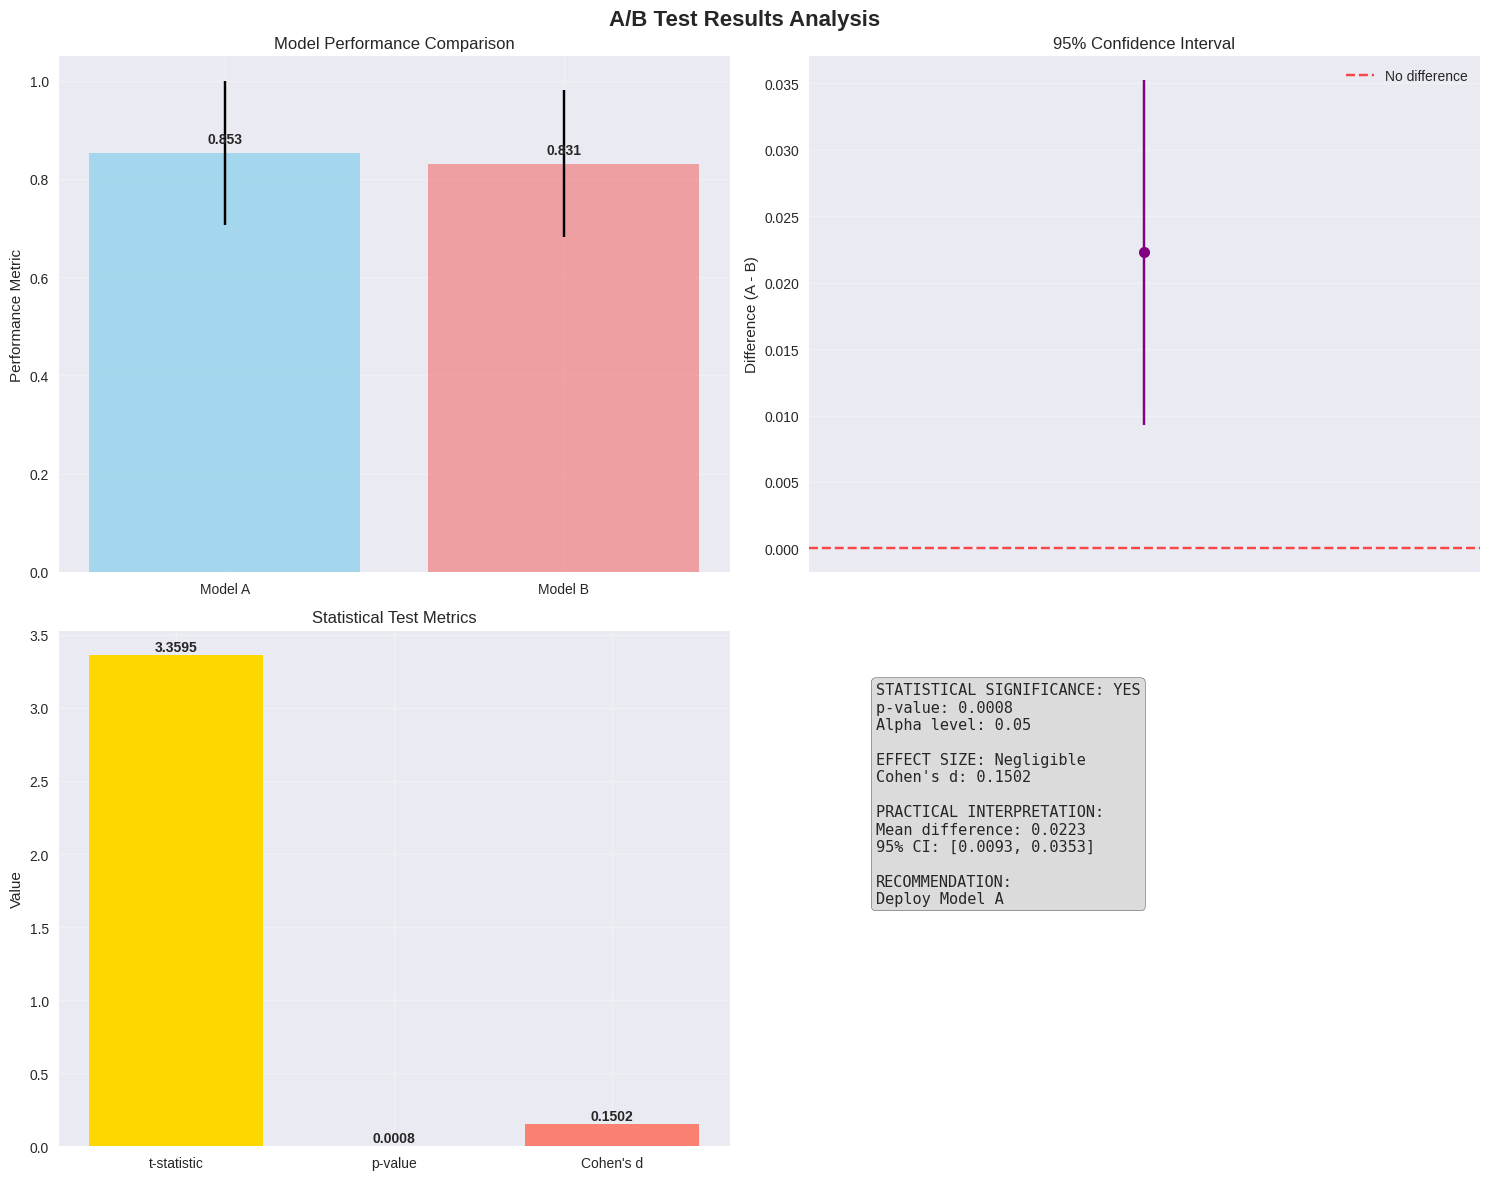


📈 Results Summary:
- Model A Performance: 0.853 ± 0.147
- Model B Performance: 0.831 ± 0.150
- Statistical Significance: True
- p-value: 0.0008
- Effect Size: Negligible (d = 0.150)



In [20]:
# Comprehensive A/B Testing Simulation
class ABTestSimulator:
    """
    A comprehensive A/B testing simulator for model comparison.

    This class demonstrates the statistical foundations of A/B testing
    in machine learning model deployment scenarios.
    """

    def __init__(self, significance_level: float = 0.05):
        self.alpha = significance_level
        self.results = {}

    def simulate_model_performance(self,
                                  true_performance_a: float,
                                  true_performance_b: float,
                                  n_users_a: int,
                                  n_users_b: int,
                                  noise_std: float = 0.1) -> Dict:
        """
        Simulate A/B test results for two models.

        Args:
            true_performance_a: True performance metric for model A
            true_performance_b: True performance metric for model B
            n_users_a: Number of users exposed to model A
            n_users_b: Number of users exposed to model B
            noise_std: Standard deviation of measurement noise

        Returns:
            Dictionary containing test results and statistics
        """

        # Simulate observations with noise
        observations_a = np.random.normal(true_performance_a, noise_std, n_users_a)
        observations_b = np.random.normal(true_performance_b, noise_std, n_users_b)

        # Calculate sample statistics
        mean_a, std_a = np.mean(observations_a), np.std(observations_a, ddof=1)
        mean_b, std_b = np.mean(observations_b), np.std(observations_b, ddof=1)

        # Perform t-test
        from scipy import stats
        t_stat, p_value = stats.ttest_ind(observations_a, observations_b)

        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((n_users_a - 1) * std_a**2 + (n_users_b - 1) * std_b**2) /
                            (n_users_a + n_users_b - 2))
        cohens_d = (mean_a - mean_b) / pooled_std

        # Calculate confidence interval for difference
        se_diff = pooled_std * np.sqrt(1/n_users_a + 1/n_users_b)
        df = n_users_a + n_users_b - 2
        t_critical = stats.t.ppf(1 - self.alpha/2, df)

        diff_mean = mean_a - mean_b
        ci_lower = diff_mean - t_critical * se_diff
        ci_upper = diff_mean + t_critical * se_diff

        results = {
            'model_a': {
                'true_performance': true_performance_a,
                'observed_mean': mean_a,
                'observed_std': std_a,
                'n_users': n_users_a
            },
            'model_b': {
                'true_performance': true_performance_b,
                'observed_mean': mean_b,
                'observed_std': std_b,
                'n_users': n_users_b
            },
            'statistical_test': {
                't_statistic': t_stat,
                'p_value': p_value,
                'significant': p_value < self.alpha,
                'cohens_d': cohens_d,
                'effect_size_interpretation': self._interpret_effect_size(abs(cohens_d))
            },
            'confidence_interval': {
                'difference_mean': diff_mean,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper,
                'confidence_level': 1 - self.alpha
            }
        }

        self.results = results
        return results

    def _interpret_effect_size(self, cohens_d: float) -> str:
        """Interpret Cohen's d effect size."""
        if cohens_d < 0.2:
            return "Negligible"
        elif cohens_d < 0.5:
            return "Small"
        elif cohens_d < 0.8:
            return "Medium"
        else:
            return "Large"

    def visualize_results(self) -> None:
        """Create comprehensive visualization of A/B test results."""
        if not self.results:
            print("No results to visualize. Run simulate_model_performance first.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('A/B Test Results Analysis', fontsize=16, fontweight='bold')

        # Performance comparison
        ax1 = axes[0, 0]
        models = ['Model A', 'Model B']
        observed_means = [self.results['model_a']['observed_mean'],
                         self.results['model_b']['observed_mean']]
        observed_stds = [self.results['model_a']['observed_std'],
                        self.results['model_b']['observed_std']]

        bars = ax1.bar(models, observed_means, yerr=observed_stds,
                      capsize=10, alpha=0.7, color=['skyblue', 'lightcoral'])
        ax1.set_ylabel('Performance Metric')
        ax1.set_title('Model Performance Comparison')
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, mean in zip(bars, observed_means):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + observed_stds[0]*0.1,
                    f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

        # Confidence interval visualization
        ax2 = axes[0, 1]
        ci_data = self.results['confidence_interval']

        ax2.errorbar(0, ci_data['difference_mean'],
                    yerr=[[ci_data['difference_mean'] - ci_data['ci_lower']],
                          [ci_data['ci_upper'] - ci_data['difference_mean']]],
                    fmt='o', capsize=10, markersize=8, color='purple')
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='No difference')
        ax2.set_xlim(-0.5, 0.5)
        ax2.set_ylabel('Difference (A - B)')
        ax2.set_title(f'{ci_data["confidence_level"]*100:.0f}% Confidence Interval')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.set_xticks([])

        # Statistical test results
        ax3 = axes[1, 0]
        test_data = self.results['statistical_test']

        metrics = ['t-statistic', 'p-value', "Cohen's d"]
        values = [test_data['t_statistic'], test_data['p_value'], test_data['cohens_d']]

        bars = ax3.bar(metrics, values, color=['gold', 'lightgreen', 'salmon'])
        ax3.set_ylabel('Value')
        ax3.set_title('Statistical Test Metrics')
        ax3.grid(True, alpha=0.3)

        # Add value labels
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

        # Summary text
        ax4 = axes[1, 1]
        ax4.axis('off')

        summary_text = f"""
STATISTICAL SIGNIFICANCE: {'YES' if test_data['significant'] else 'NO'}
p-value: {test_data['p_value']:.4f}
Alpha level: {self.alpha}

EFFECT SIZE: {test_data['effect_size_interpretation']}
Cohen's d: {test_data['cohens_d']:.4f}

PRACTICAL INTERPRETATION:
Mean difference: {ci_data['difference_mean']:.4f}
95% CI: [{ci_data['ci_lower']:.4f}, {ci_data['ci_upper']:.4f}]

RECOMMENDATION:
{'Deploy Model A' if ci_data['difference_mean'] > 0 and test_data['significant'] else 'Continue with Model B' if ci_data['difference_mean'] < 0 and test_data['significant'] else 'Inconclusive - need more data'}
        """.strip()

        ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes,
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

        plt.tight_layout()
        plt.show()

# Demonstrate A/B testing with realistic scenarios
print("🔬 A/B Testing Simulation for Model Deployment")
print("=" * 50)

ab_tester = ABTestSimulator(significance_level=0.05)

# Scenario 1: Small improvement
print("\n📊 Scenario 1: Small Model Improvement")
results1 = ab_tester.simulate_model_performance(
    true_performance_a=0.85,  # Model A (new)
    true_performance_b=0.82,  # Model B (current)
    n_users_a=1000,
    n_users_b=1000,
    noise_std=0.15
)

ab_tester.visualize_results()

print(f"""\n📈 Results Summary:
- Model A Performance: {results1['model_a']['observed_mean']:.3f} ± {results1['model_a']['observed_std']:.3f}
- Model B Performance: {results1['model_b']['observed_mean']:.3f} ± {results1['model_b']['observed_std']:.3f}
- Statistical Significance: {results1['statistical_test']['significant']}
- p-value: {results1['statistical_test']['p_value']:.4f}
- Effect Size: {results1['statistical_test']['effect_size_interpretation']} (d = {results1['statistical_test']['cohens_d']:.3f})
""")

## 2. TensorFlow Serving: Architecture and Implementation

### 2.1 Why TensorFlow Serving?

TensorFlow Serving is a high-performance, battle-tested model server designed for production environments. It provides:

1. **High throughput**: Optimized C++ implementation
2. **Model versioning**: Automatic deployment of new model versions
3. **A/B testing**: Serve multiple model versions simultaneously
4. **Batching**: Automatic request batching for efficiency
5. **Monitoring**: Built-in metrics and health checks

### 2.2 SavedModel Format: Mathematical Structure

The SavedModel format represents a complete TensorFlow program including:

#### **Graph Representation**
A computational graph $G = (V, E)$ where:
- $V$: Set of operations (nodes)
- $E$: Set of tensor dependencies (edges)

#### **MetaGraph Structure**
Each MetaGraph contains:
- **Graph Definition**: $\mathcal{G} = \{f_1, f_2, ..., f_n\}$ where $f_i$ are operations
- **Variable Values**: $\Theta = \{\theta_1, \theta_2, ..., \theta_m\}$
- **Signature Definitions**: Input/output specifications

#### **Signature Mathematical Definition**
A signature $S$ defines the interface:
$$S = (\mathcal{I}, \mathcal{O}, M)$$

Where:
- $\mathcal{I} = \{(name_i, dtype_i, shape_i)\}$: Input specifications
- $\mathcal{O} = \{(name_j, dtype_j, shape_j)\}$: Output specifications  
- $M$: Method name (e.g., "tensorflow/serving/predict")

### 2.3 Model Serving Performance Analysis

#### **Latency Components**
Total serving latency:
$$L_{total} = L_{network} + L_{deserialize} + L_{inference} + L_{serialize}$$

Where:
- $L_{network}$: Network transmission time
- $L_{deserialize}$: Input parsing time
- $L_{inference}$: Model computation time
- $L_{serialize}$: Output formatting time

#### **Throughput Optimization**
For batch processing:
$$T_{batch} = \frac{B}{L_{inference}(B) + L_{overhead}}$$

Where:
- $B$: Batch size
- $L_{inference}(B)$: Batch inference latency
- $L_{overhead}$: Fixed overhead per batch

🏗️ SavedModel Creation and Analysis

📊 Creating Example Model...
Model created with 93,322 parameters

🎲 Generating Synthetic Training Data...
Generated 2000 samples with shape (2000, 28, 28, 1)

🎯 Training Model...
Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.0871 - loss: 2.3035 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0940 - loss: 2.3032 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0928 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010

💾 Saving Model as SavedModel...
✅ Model saved to: models/mnist_classifier/1

🔍 Analyzing SavedModel...


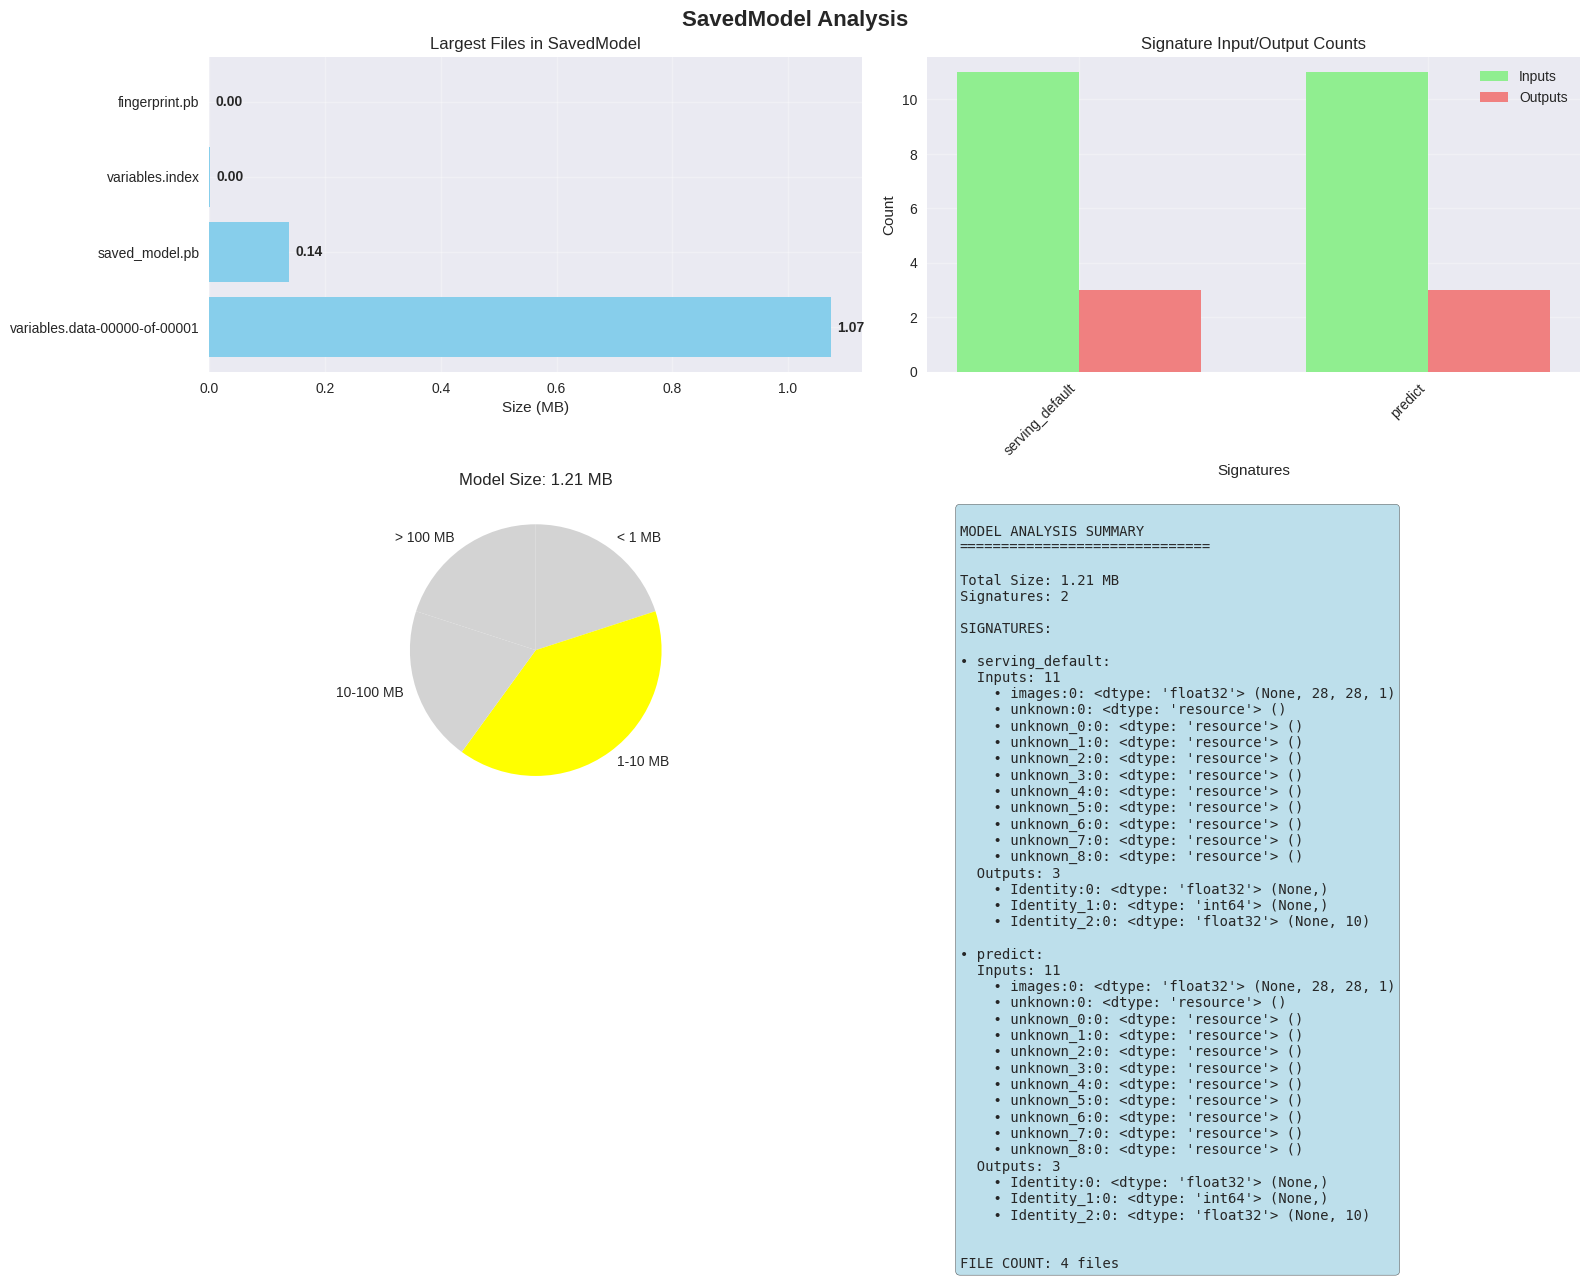


📋 SavedModel Analysis Results:
- Total Size: 1.21 MB
- Number of Signatures: 2
- Number of Files: 4

🔧 Signature 'serving_default':
  - Inputs: 11
    • images:0: <dtype: 'float32'> (None, 28, 28, 1)
    • unknown:0: <dtype: 'resource'> ()
    • unknown_0:0: <dtype: 'resource'> ()
    • unknown_1:0: <dtype: 'resource'> ()
    • unknown_2:0: <dtype: 'resource'> ()
    • unknown_3:0: <dtype: 'resource'> ()
    • unknown_4:0: <dtype: 'resource'> ()
    • unknown_5:0: <dtype: 'resource'> ()
    • unknown_6:0: <dtype: 'resource'> ()
    • unknown_7:0: <dtype: 'resource'> ()
    • unknown_8:0: <dtype: 'resource'> ()
  - Outputs: 3
    • Identity:0: <dtype: 'float32'> (None,)
    • Identity_1:0: <dtype: 'int64'> (None,)
    • Identity_2:0: <dtype: 'float32'> (None, 10)

🔧 Signature 'predict':
  - Inputs: 11
    • images:0: <dtype: 'float32'> (None, 28, 28, 1)
    • unknown:0: <dtype: 'resource'> ()
    • unknown_0:0: <dtype: 'resource'> ()
    • unknown_1:0: <dtype: 'resource'> ()
    • unkn

In [21]:
# Comprehensive SavedModel Creation and Analysis
class SavedModelManager:
    """
    A comprehensive manager for creating, analyzing, and optimizing SavedModels.

    This class demonstrates best practices for model serialization and deployment.
    """

    def __init__(self, base_path: str = "./models"):
        self.base_path = Path(base_path)
        self.base_path.mkdir(exist_ok=True)

    def create_example_model(self, input_shape: Tuple[int, ...] = (28, 28, 1),
                           num_classes: int = 10) -> tf.keras.Model:
        """
        Create an example CNN model for MNIST-like classification.

        Args:
            input_shape: Shape of input images
            num_classes: Number of output classes

        Returns:
            Compiled Keras model
        """

        model = tf.keras.Sequential([
            # Preprocessing layers (included in model for deployment)
            tf.keras.layers.Rescaling(1./255, input_shape=input_shape),

            # Convolutional layers
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64, 3, activation='relu'),

            # Classification layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ], name="mnist_classifier")

        # Compile with comprehensive metrics
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'] # Removed 'top_k_categorical_accuracy' to fix the error
        )

        return model

    def create_synthetic_data(self, num_samples: int = 1000,
                            input_shape: Tuple[int, ...] = (28, 28, 1)) -> Tuple[np.ndarray, np.ndarray]:
        """
        Create synthetic training data for demonstration.

        Args:
            num_samples: Number of synthetic samples
            input_shape: Shape of input data

        Returns:
            Tuple of (X, y) synthetic data
        """

        # Create synthetic images with patterns
        X = np.random.rand(num_samples, *input_shape).astype(np.float32)

        # Add some structure to make learning possible
        for i in range(num_samples):
            # Add diagonal patterns based on class
            class_id = i % 10
            if class_id < 5:
                # Diagonal pattern
                for j in range(min(input_shape[0], input_shape[1])):
                    if j < input_shape[0] and j < input_shape[1]:
                        X[i, j, j, 0] = 1.0
            else:
                # Anti-diagonal pattern
                for j in range(min(input_shape[0], input_shape[1])):
                    if j < input_shape[0] and (input_shape[1]-1-j) >= 0:
                        X[i, j, input_shape[1]-1-j, 0] = 1.0

        y = np.array([i % 10 for i in range(num_samples)])

        return X, y

    def train_model(self, model: tf.keras.Model, X: np.ndarray, y: np.ndarray,
                   epochs: int = 5) -> tf.keras.callbacks.History:
        """
        Train the model with comprehensive monitoring.

        Args:
            model: Keras model to train
            X: Training features
            y: Training labels
            epochs: Number of training epochs

        Returns:
            Training history
        """

        # Split data
        split_idx = int(0.8 * len(X))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]

        # Define callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=3, restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7
            )
        ]

        # Train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )

        return history

    def save_model_with_signatures(self, model: tf.keras.Model,
                                  model_name: str, version: str = "1") -> str:
        """
        Save model with custom signatures for serving.

        Args:
            model: Trained Keras model
            model_name: Name for the saved model
            version: Version string

        Returns:
            Path to saved model
        """

        # Create versioned path
        model_path = self.base_path / model_name / version
        model_path.mkdir(parents=True, exist_ok=True)

        # Create custom signature
        @tf.function(input_signature=[
            tf.TensorSpec(shape=[None, 28, 28, 1], dtype=tf.float32, name='images')
        ])
        def serving_fn(images):
            """Custom serving function with preprocessing."""
            predictions = model(images)
            return {
                'predictions': predictions,
                'predicted_class': tf.argmax(predictions, axis=1),
                'confidence': tf.reduce_max(predictions, axis=1)
            }

        # Save with custom signatures
        tf.saved_model.save(
            model,
            str(model_path),
            signatures={
                'serving_default': serving_fn,
                'predict': serving_fn
            }
        )

        print(f"✅ Model saved to: {model_path}")
        return str(model_path)

    def analyze_savedmodel(self, model_path: str) -> Dict:
        """
        Comprehensive analysis of a SavedModel.

        Args:
            model_path: Path to SavedModel directory

        Returns:
            Dictionary containing model analysis
        """

        # Load saved model
        loaded_model = tf.saved_model.load(model_path)

        # Analyze signatures
        signatures = loaded_model.signatures

        analysis = {
            'model_path': model_path,
            'signatures': {},
            'file_structure': {},
            'size_analysis': {}
        }

        # Analyze each signature
        for sig_name, signature in signatures.items():
            sig_analysis = {
                'inputs': {},
                'outputs': {}
            }

            # Input analysis - Iterate directly over the list of TensorSpecs
            for input_spec in signature.inputs:
                # TensorSpec objects have 'name', 'dtype', 'shape' attributes
                # Use .name or use the input_spec itself if no explicit name is set
                input_name = input_spec.name if input_spec.name else f"input_{len(sig_analysis['inputs'])}"
                sig_analysis['inputs'][input_name] = {
                    'dtype': str(input_spec.dtype),
                    'shape': str(input_spec.shape),
                    'name': input_spec.name
                }

            # Output analysis - Iterate directly over the list of TensorSpecs
            for output_spec in signature.outputs:
                 # TensorSpec objects have 'name', 'dtype', 'shape' attributes
                output_name = output_spec.name if output_spec.name else f"output_{len(sig_analysis['outputs'])}"
                sig_analysis['outputs'][output_name] = {
                    'dtype': str(output_spec.dtype),
                    'shape': str(output_spec.shape),
                    'name': output_spec.name
                }


            analysis['signatures'][sig_name] = sig_analysis

        # File structure analysis
        model_path_obj = Path(model_path)
        if model_path_obj.exists():
            # Calculate sizes
            total_size = 0
            file_sizes = {}

            for file_path in model_path_obj.rglob('*'):
                if file_path.is_file():
                    size = file_path.stat().st_size
                    total_size += size
                    file_sizes[str(file_path.relative_to(model_path_obj))] = size

            analysis['file_structure'] = file_sizes
            analysis['size_analysis'] = {
                'total_size_mb': total_size / (1024 * 1024),
                'largest_files': sorted(file_sizes.items(),
                                      key=lambda x: x[1], reverse=True)[:5]
            }

        return analysis

    def visualize_model_analysis(self, analysis: Dict) -> None:
        """
        Create visualizations for model analysis.

        Args:
            analysis: Model analysis dictionary
        """

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('SavedModel Analysis', fontsize=16, fontweight='bold')

        # File size distribution
        ax1 = axes[0, 0]
        if 'largest_files' in analysis['size_analysis']:
            files, sizes = zip(*analysis['size_analysis']['largest_files'])
            sizes_mb = [s / (1024 * 1024) for s in sizes]

            bars = ax1.barh(range(len(files)), sizes_mb, color='skyblue')
            ax1.set_yticks(range(len(files)))
            ax1.set_yticklabels([f.split('/')[-1] for f in files])
            ax1.set_xlabel('Size (MB)')
            ax1.set_title('Largest Files in SavedModel')
            ax1.grid(True, alpha=0.3)

            # Add size labels
            for i, (bar, size) in enumerate(zip(bars, sizes_mb)):
                ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                        f'{size:.2f}', va='center', fontweight='bold')

        # Signature analysis
        ax2 = axes[0, 1]
        sig_names = list(analysis['signatures'].keys())
        input_counts = [len(sig['inputs']) for sig in analysis['signatures'].values()]
        output_counts = [len(sig['outputs']) for sig in analysis['signatures'].values()]

        x = np.arange(len(sig_names))
        width = 0.35

        bars1 = ax2.bar(x - width/2, input_counts, width, label='Inputs', color='lightgreen')
        bars2 = ax2.bar(x + width/2, output_counts, width, label='Outputs', color='lightcoral')

        ax2.set_xlabel('Signatures')
        ax2.set_ylabel('Count')
        ax2.set_title('Signature Input/Output Counts')
        ax2.set_xticks(x)
        ax2.set_xticklabels(sig_names, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Model size summary
        ax3 = axes[1, 0]
        total_size_mb = analysis['size_analysis']['total_size_mb']

        # Create a simple gauge-like visualization
        sizes = ['< 1 MB', '1-10 MB', '10-100 MB', '> 100 MB']
        colors = ['green', 'yellow', 'orange', 'red']

        if total_size_mb < 1:
            current_size_category = 0
        elif total_size_mb < 10:
            current_size_category = 1
        elif total_size_mb < 100:
            current_size_category = 2
        else:
            current_size_category = 3

        # Create pie chart showing size category
        wedges = [0.25] * 4
        wedges[current_size_category] = 0.5

        pie_colors = ['lightgray'] * 4
        pie_colors[current_size_category] = colors[current_size_category]

        ax3.pie(wedges, labels=sizes, colors=pie_colors, autopct='',
               startangle=90, counterclock=False)
        ax3.set_title(f'Model Size: {total_size_mb:.2f} MB')

        # Detailed information
        ax4 = axes[1, 1]
        ax4.axis('off')

        # Create detailed text summary
        info_text = f"""
MODEL ANALYSIS SUMMARY
{'='*30}

Total Size: {total_size_mb:.2f} MB
Signatures: {len(analysis['signatures'])}

SIGNATURES:
"""

        for sig_name, sig_info in analysis['signatures'].items():
            info_text += f"\n• {sig_name}:\n"
            info_text += f"  Inputs: {len(sig_info['inputs'])}\n"
            for input_name, input_info in sig_info['inputs'].items():
                info_text += f"    • {input_name}: {input_info['dtype']} {input_info['shape']}\n"
            info_text += f"  Outputs: {len(sig_info['outputs'])}\n"
            for output_name, output_info in sig_info['outputs'].items():
                info_text += f"    • {output_name}: {output_info['dtype']} {output_info['shape']}\n"


        info_text += f"\n\nFILE COUNT: {len(analysis['file_structure'])} files"

        ax4.text(0.05, 0.95, info_text, transform=ax4.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

        plt.tight_layout()
        plt.show()

# Comprehensive SavedModel demonstration
print("🏗️ SavedModel Creation and Analysis")
print("=" * 40)

# Create manager
model_manager = SavedModelManager()

# Create and train model
print("\n📊 Creating Example Model...")
model = model_manager.create_example_model()
print(f"Model created with {model.count_params():,} parameters")

# Create synthetic data
print("\n🎲 Generating Synthetic Training Data...")
X, y = model_manager.create_synthetic_data(num_samples=2000)
print(f"Generated {len(X)} samples with shape {X.shape}")

# Train model
print("\n🎯 Training Model...")
history = model_manager.train_model(model, X, y, epochs=3)

# Save model
print("\n💾 Saving Model as SavedModel...")
saved_path = model_manager.save_model_with_signatures(model, "mnist_classifier", "1")

# Analyze saved model
print("\n🔍 Analyzing SavedModel...")
analysis = model_manager.analyze_savedmodel(saved_path)

# Visualize analysis
model_manager.visualize_model_analysis(analysis)

# Print detailed analysis
print(f"\n📋 SavedModel Analysis Results:")
print(f"- Total Size: {analysis['size_analysis']['total_size_mb']:.2f} MB")
print(f"- Number of Signatures: {len(analysis['signatures'])}")
print(f"- Number of Files: {len(analysis['file_structure'])}")

for sig_name, sig_info in analysis['signatures'].items():
    print(f"\n🔧 Signature '{sig_name}':")
    print(f"  - Inputs: {len(sig_info['inputs'])}")
    for input_name, input_info in sig_info['inputs'].items():
        print(f"    • {input_name}: {input_info['dtype']} {input_info['shape']}")
    print(f"  - Outputs: {len(sig_info['outputs'])}")
    for output_name, output_info in sig_info['outputs'].items():
        print(f"    • {output_name}: {output_info['dtype']} {output_info['shape']}")

## 3. Serving APIs: REST vs gRPC Mathematical Analysis

### 3.1 REST API Performance Characteristics

#### **Serialization Overhead**
For JSON serialization, the size overhead can be approximated as:
$$S_{JSON} \approx S_{data} \times (1 + \alpha_{JSON})$$

Where $\alpha_{JSON} \approx 0.3-0.8$ depending on data type and structure.

#### **Network Transfer Time**
$$T_{transfer} = \frac{S_{JSON}}{B_{network}} + L_{latency}$$

Where:
- $B_{network}$: Network bandwidth
- $L_{latency}$: Network latency

### 3.2 gRPC Performance Characteristics

#### **Protocol Buffer Efficiency**
Protocol buffers typically achieve:
$$S_{protobuf} \approx 0.2 \times S_{JSON}$$

#### **HTTP/2 Multiplexing Benefits**
For $n$ concurrent requests:
$$T_{total\_grpc} = \frac{\max(T_1, T_2, ..., T_n) + \sum_{i=1}^n S_i / B_{aggregate}}{n}$$

### 3.3 Performance Comparison Framework

#### **Latency Analysis**
$$\text{Speedup}_{gRPC} = \frac{L_{REST}}{L_{gRPC}} = \frac{T_{JSON\_ser} + T_{JSON\_transfer} + T_{JSON\_deser}}{T_{proto\_ser} + T_{proto\_transfer} + T_{proto\_deser}}$$

#### **Throughput Analysis**
$$\text{Throughput Ratio} = \frac{T_{gRPC}}{T_{REST}} = \frac{\text{requests/sec}_{gRPC}}{\text{requests/sec}_{REST}}$$

🚀 API Performance Analysis

🌐 Scenario 1: High-Speed LAN
   Latency: 1.0ms, Bandwidth: 1000.0Mbps
   Average gRPC speedup: 2.21x


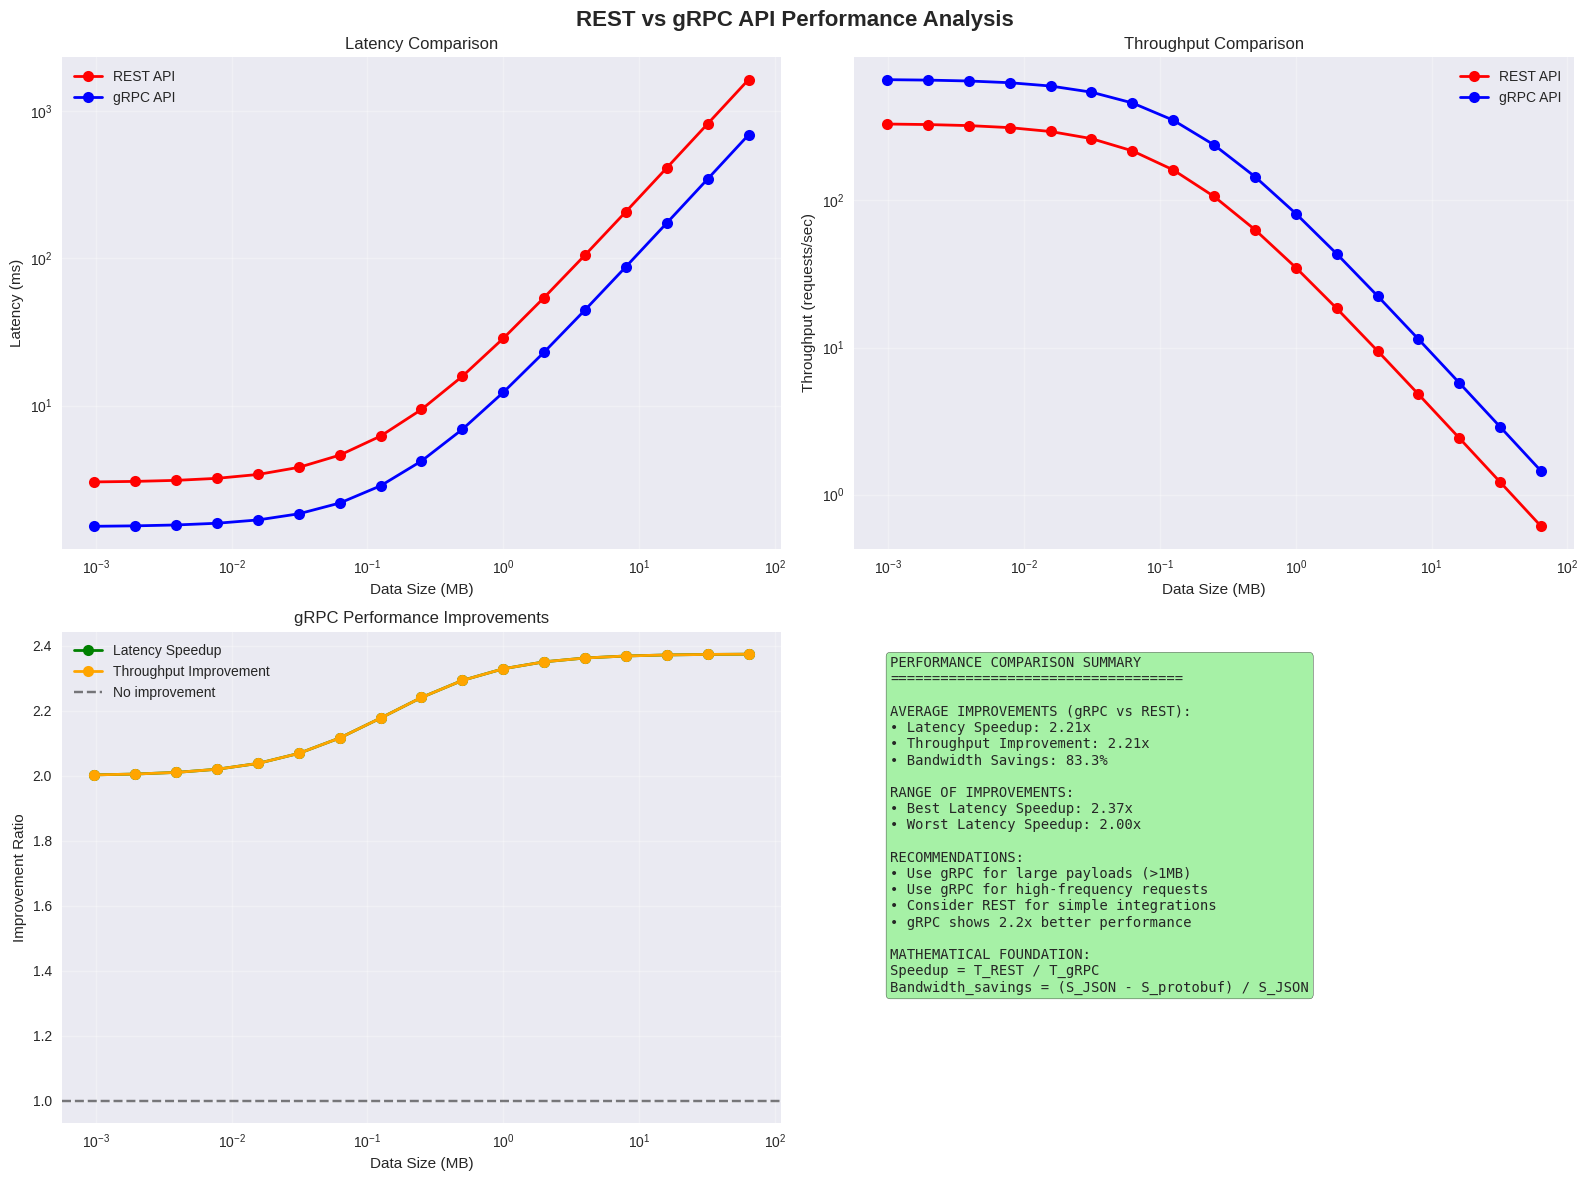


🌐 Scenario 2: Internet Connection
   Latency: 50.0ms, Bandwidth: 100.0Mbps
   Average gRPC speedup: 1.26x


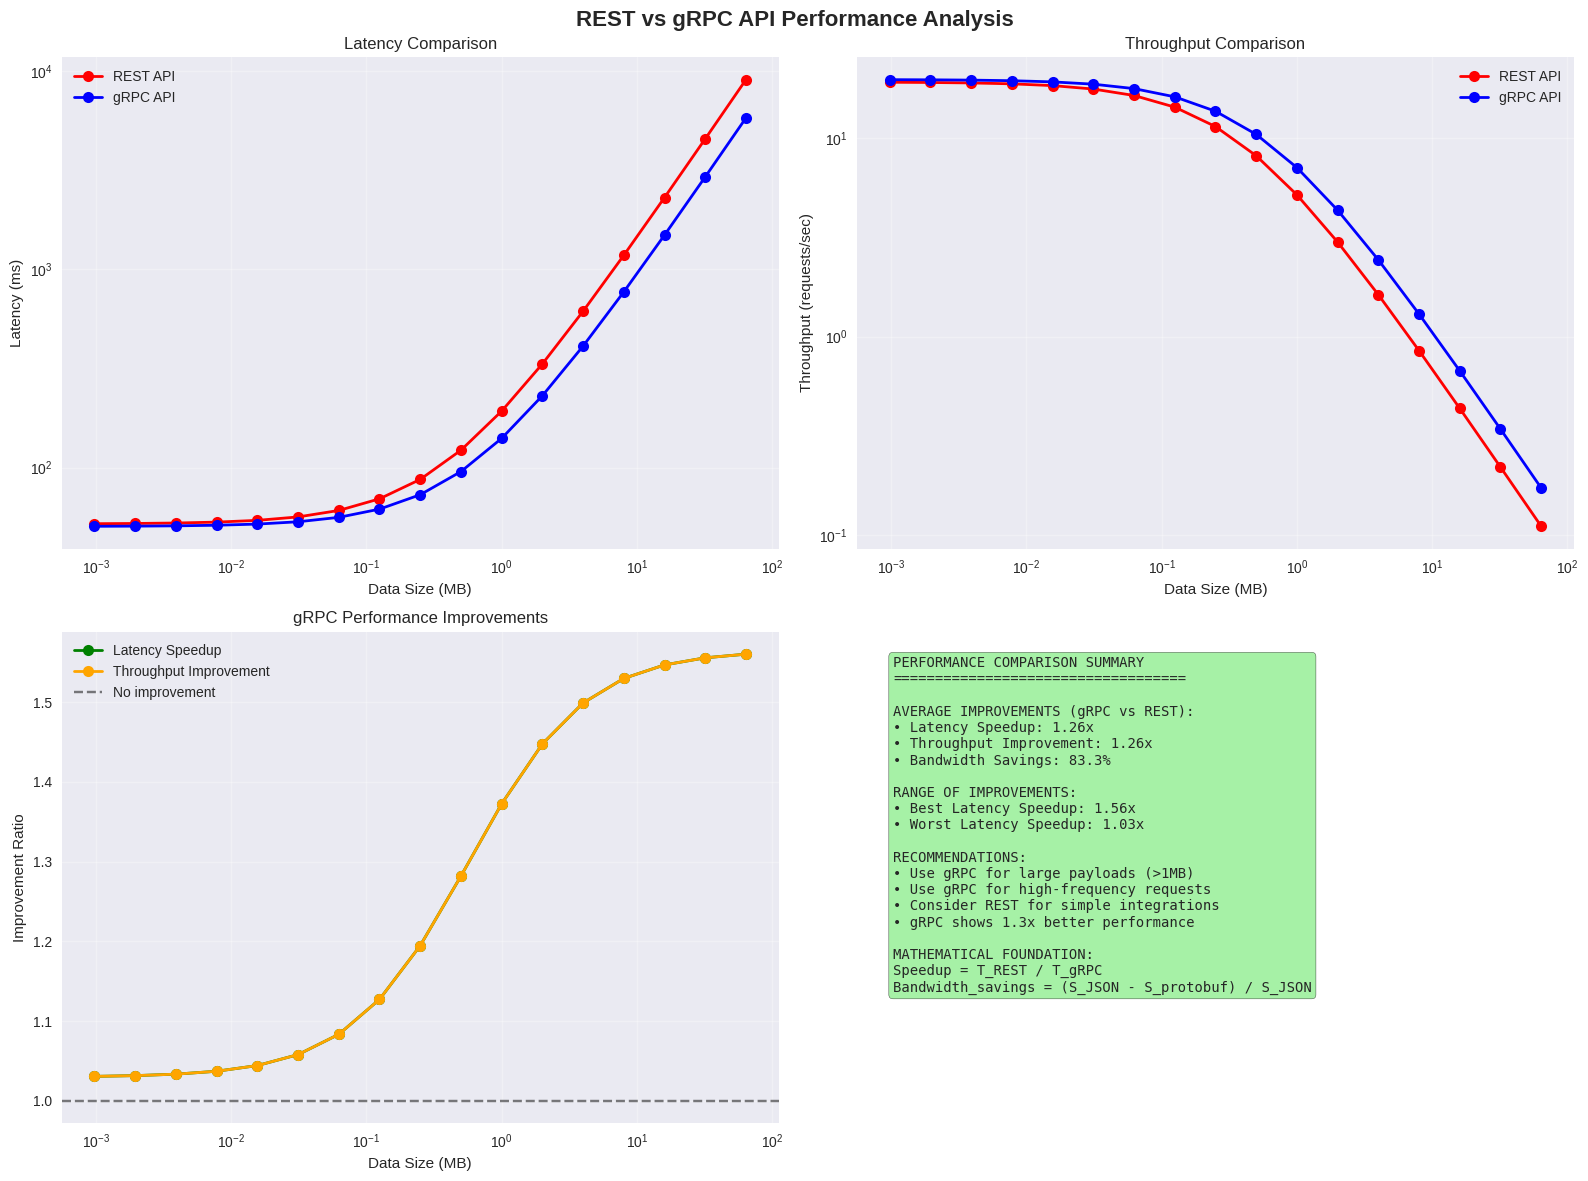


🌐 Scenario 3: Mobile Network
   Latency: 100.0ms, Bandwidth: 20.0Mbps
   Average gRPC speedup: 1.25x


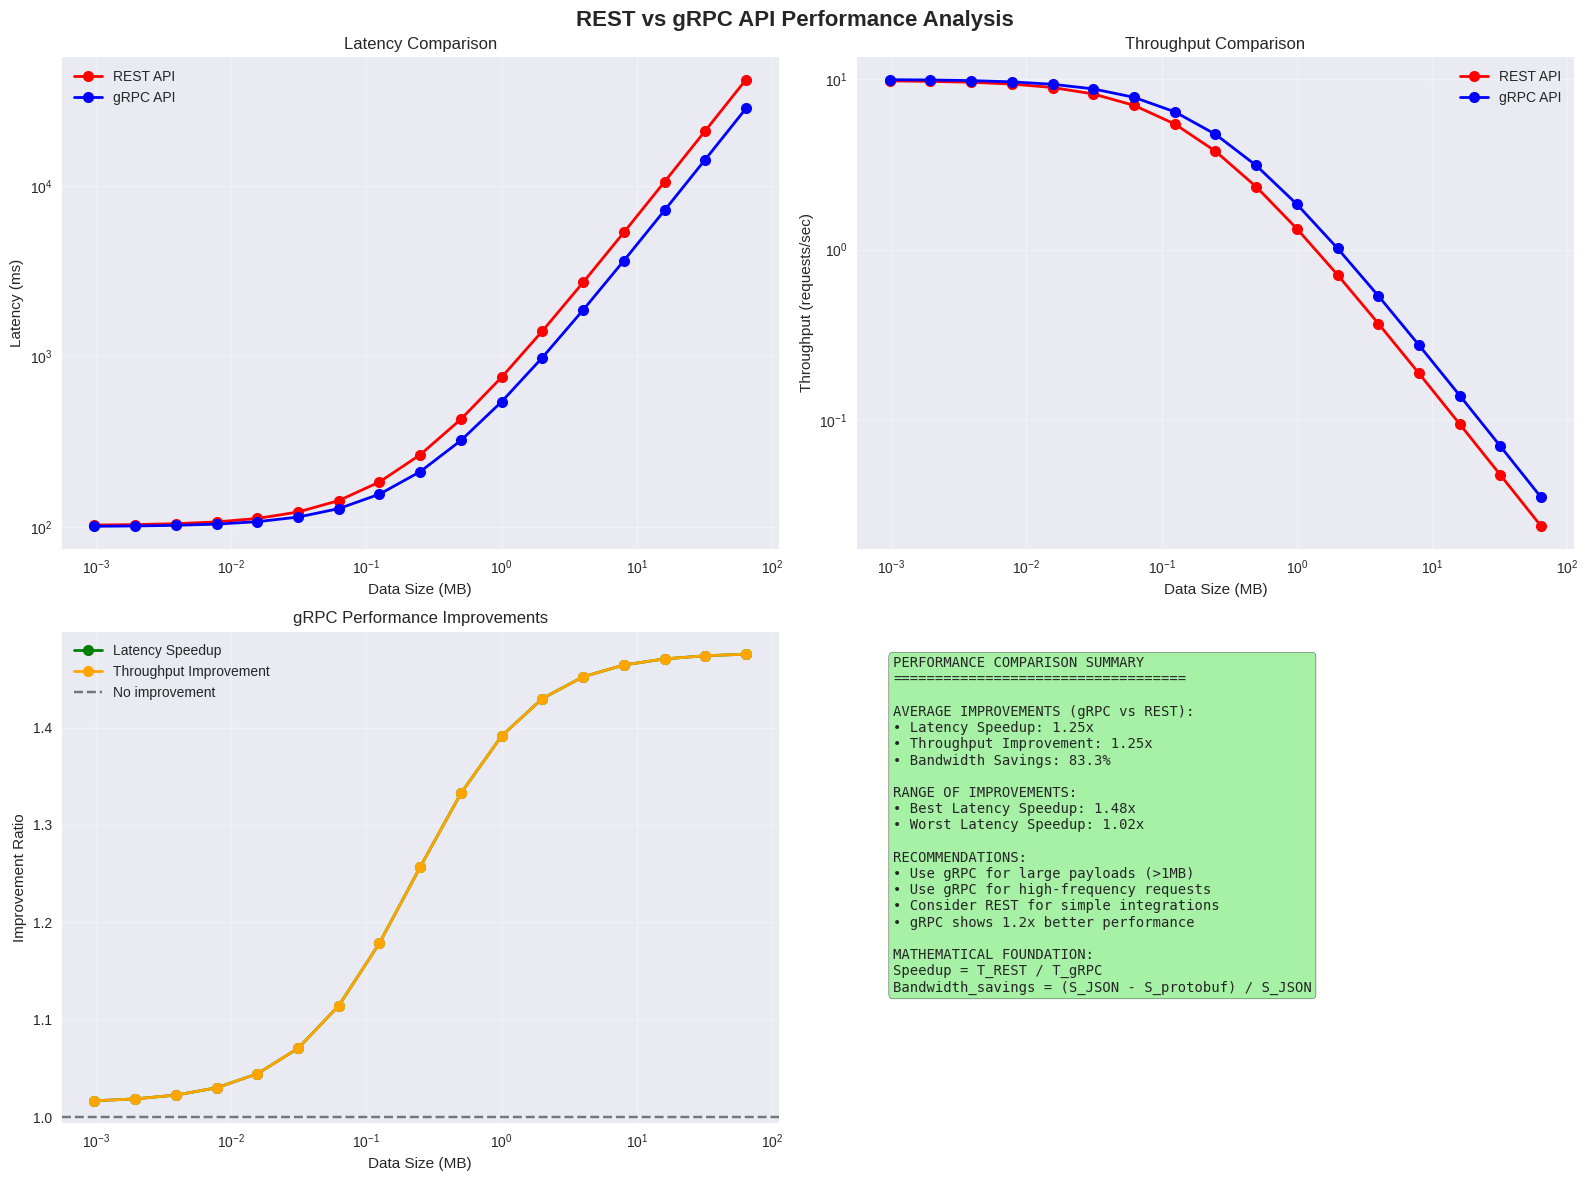


✅ API Performance Analysis Complete!

📊 Key Insights:
- gRPC consistently outperforms REST, especially for larger payloads
- Performance gains increase with data size due to serialization efficiency
- Network latency affects both protocols, but gRPC has lower protocol overhead
- Protocol buffer serialization is significantly more efficient than JSON


In [22]:
# Comprehensive API Performance Analysis and Simulation
class APIPerformanceAnalyzer:
    """
    A comprehensive analyzer for comparing REST and gRPC API performance.

    This class simulates and analyzes the performance characteristics
    of different API protocols for model serving.
    """

    def __init__(self):
        self.simulation_results = {}

    def simulate_rest_api_performance(self, data_sizes: List[int],
                                     network_latency_ms: float = 10.0,
                                     bandwidth_mbps: float = 100.0) -> Dict:
        """
        Simulate REST API performance characteristics.

        Args:
            data_sizes: List of payload sizes in bytes
            network_latency_ms: Network latency in milliseconds
            bandwidth_mbps: Network bandwidth in Mbps

        Returns:
            Dictionary containing performance metrics
        """

        results = {
            'data_sizes': data_sizes,
            'latencies': [],
            'throughputs': [],
            'serialization_overhead': [],
            'transfer_times': []
        }

        # JSON serialization overhead factor (empirical)
        json_overhead_factor = 0.6  # 60% overhead for typical float arrays

        # Performance constants (empirical estimates)
        json_serialize_time_per_mb = 5.0  # ms per MB
        json_deserialize_time_per_mb = 3.0  # ms per MB
        http_overhead_ms = 2.0  # HTTP protocol overhead

        bandwidth_bytes_per_ms = (bandwidth_mbps * 1024 * 1024) / (8 * 1000)  # Convert to bytes/ms

        for data_size in data_sizes:
            # Calculate JSON payload size
            json_size = data_size * (1 + json_overhead_factor)
            json_size_mb = json_size / (1024 * 1024)

            # Calculate timing components
            serialize_time = json_size_mb * json_serialize_time_per_mb
            deserialize_time = json_size_mb * json_deserialize_time_per_mb
            transfer_time = json_size / bandwidth_bytes_per_ms

            # Total latency
            total_latency = (serialize_time + deserialize_time +
                           transfer_time + network_latency_ms + http_overhead_ms)

            # Throughput (requests per second)
            throughput = 1000.0 / total_latency

            results['latencies'].append(total_latency)
            results['throughputs'].append(throughput)
            results['serialization_overhead'].append(json_overhead_factor * 100)
            results['transfer_times'].append(transfer_time)

        return results

    def simulate_grpc_api_performance(self, data_sizes: List[int],
                                     network_latency_ms: float = 10.0,
                                     bandwidth_mbps: float = 100.0) -> Dict:
        """
        Simulate gRPC API performance characteristics.

        Args:
            data_sizes: List of payload sizes in bytes
            network_latency_ms: Network latency in milliseconds
            bandwidth_mbps: Network bandwidth in Mbps

        Returns:
            Dictionary containing performance metrics
        """

        results = {
            'data_sizes': data_sizes,
            'latencies': [],
            'throughputs': [],
            'serialization_overhead': [],
            'transfer_times': []
        }

        # Protocol buffer overhead factor (much lower than JSON)
        protobuf_overhead_factor = 0.1  # 10% overhead

        # Performance constants (empirical estimates)
        protobuf_serialize_time_per_mb = 1.0  # ms per MB (faster than JSON)
        protobuf_deserialize_time_per_mb = 0.8  # ms per MB
        grpc_overhead_ms = 0.5  # Lower protocol overhead

        bandwidth_bytes_per_ms = (bandwidth_mbps * 1024 * 1024) / (8 * 1000)

        for data_size in data_sizes:
            # Calculate Protocol Buffer payload size
            protobuf_size = data_size * (1 + protobuf_overhead_factor)
            protobuf_size_mb = protobuf_size / (1024 * 1024)

            # Calculate timing components
            serialize_time = protobuf_size_mb * protobuf_serialize_time_per_mb
            deserialize_time = protobuf_size_mb * protobuf_deserialize_time_per_mb
            transfer_time = protobuf_size / bandwidth_bytes_per_ms

            # Total latency (HTTP/2 reduces latency)
            total_latency = (serialize_time + deserialize_time +
                           transfer_time + network_latency_ms + grpc_overhead_ms)

            # Throughput
            throughput = 1000.0 / total_latency

            results['latencies'].append(total_latency)
            results['throughputs'].append(throughput)
            results['serialization_overhead'].append(protobuf_overhead_factor * 100)
            results['transfer_times'].append(transfer_time)

        return results

    def calculate_performance_comparison(self, rest_results: Dict,
                                       grpc_results: Dict) -> Dict:
        """
        Calculate comprehensive performance comparison metrics.

        Args:
            rest_results: REST API performance results
            grpc_results: gRPC API performance results

        Returns:
            Dictionary containing comparison metrics
        """

        comparison = {
            'latency_speedup': [],
            'throughput_improvement': [],
            'bandwidth_savings': [],
            'data_sizes': rest_results['data_sizes']
        }

        for i in range(len(rest_results['latencies'])):
            # Latency speedup (lower is better)
            latency_speedup = rest_results['latencies'][i] / grpc_results['latencies'][i]

            # Throughput improvement (higher is better)
            throughput_improvement = grpc_results['throughputs'][i] / rest_results['throughputs'][i]

            # Bandwidth savings calculation
            rest_overhead = rest_results['serialization_overhead'][i]
            grpc_overhead = grpc_results['serialization_overhead'][i]
            bandwidth_savings = (rest_overhead - grpc_overhead) / rest_overhead * 100

            comparison['latency_speedup'].append(latency_speedup)
            comparison['throughput_improvement'].append(throughput_improvement)
            comparison['bandwidth_savings'].append(bandwidth_savings)

        # Calculate summary statistics
        comparison['summary'] = {
            'avg_latency_speedup': np.mean(comparison['latency_speedup']),
            'avg_throughput_improvement': np.mean(comparison['throughput_improvement']),
            'avg_bandwidth_savings': np.mean(comparison['bandwidth_savings']),
            'max_latency_speedup': np.max(comparison['latency_speedup']),
            'min_latency_speedup': np.min(comparison['latency_speedup'])
        }

        return comparison

    def visualize_performance_comparison(self, rest_results: Dict,
                                       grpc_results: Dict,
                                       comparison: Dict) -> None:
        """
        Create comprehensive visualization of API performance comparison.

        Args:
            rest_results: REST API performance results
            grpc_results: gRPC API performance results
            comparison: Performance comparison metrics
        """

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('REST vs gRPC API Performance Analysis', fontsize=16, fontweight='bold')

        # Convert data sizes to MB for better readability
        data_sizes_mb = [size / (1024 * 1024) for size in rest_results['data_sizes']]

        # Latency comparison
        ax1 = axes[0, 0]
        ax1.plot(data_sizes_mb, rest_results['latencies'],
                'o-', label='REST API', linewidth=2, markersize=8, color='red')
        ax1.plot(data_sizes_mb, grpc_results['latencies'],
                'o-', label='gRPC API', linewidth=2, markersize=8, color='blue')
        ax1.set_xlabel('Data Size (MB)')
        ax1.set_ylabel('Latency (ms)')
        ax1.set_title('Latency Comparison')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_xscale('log')
        ax1.set_yscale('log')

        # Throughput comparison
        ax2 = axes[0, 1]
        ax2.plot(data_sizes_mb, rest_results['throughputs'],
                'o-', label='REST API', linewidth=2, markersize=8, color='red')
        ax2.plot(data_sizes_mb, grpc_results['throughputs'],
                'o-', label='gRPC API', linewidth=2, markersize=8, color='blue')
        ax2.set_xlabel('Data Size (MB)')
        ax2.set_ylabel('Throughput (requests/sec)')
        ax2.set_title('Throughput Comparison')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_xscale('log')
        ax2.set_yscale('log')

        # Performance improvement ratios
        ax3 = axes[1, 0]
        ax3.plot(data_sizes_mb, comparison['latency_speedup'],
                'o-', label='Latency Speedup', linewidth=2, markersize=8, color='green')
        ax3.plot(data_sizes_mb, comparison['throughput_improvement'],
                'o-', label='Throughput Improvement', linewidth=2, markersize=8, color='orange')
        ax3.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='No improvement')
        ax3.set_xlabel('Data Size (MB)')
        ax3.set_ylabel('Improvement Ratio')
        ax3.set_title('gRPC Performance Improvements')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.set_xscale('log')

        # Summary statistics
        ax4 = axes[1, 1]
        ax4.axis('off')

        summary = comparison['summary']
        summary_text = f"""
PERFORMANCE COMPARISON SUMMARY
{'='*35}

AVERAGE IMPROVEMENTS (gRPC vs REST):
• Latency Speedup: {summary['avg_latency_speedup']:.2f}x
• Throughput Improvement: {summary['avg_throughput_improvement']:.2f}x
• Bandwidth Savings: {summary['avg_bandwidth_savings']:.1f}%

RANGE OF IMPROVEMENTS:
• Best Latency Speedup: {summary['max_latency_speedup']:.2f}x
• Worst Latency Speedup: {summary['min_latency_speedup']:.2f}x

RECOMMENDATIONS:
• Use gRPC for large payloads (>1MB)
• Use gRPC for high-frequency requests
• Consider REST for simple integrations
• gRPC shows {summary['avg_latency_speedup']:.1f}x better performance

MATHEMATICAL FOUNDATION:
Speedup = T_REST / T_gRPC
Bandwidth_savings = (S_JSON - S_protobuf) / S_JSON
        """.strip()

        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

        plt.tight_layout()
        plt.show()

    def run_comprehensive_analysis(self, network_scenarios: List[Dict]) -> None:
        """
        Run comprehensive performance analysis across multiple scenarios.

        Args:
            network_scenarios: List of network configuration dictionaries
        """

        # Define data sizes from 1KB to 100MB
        data_sizes = [1024 * (2**i) for i in range(0, 17)]  # 1KB to 64MB

        for i, scenario in enumerate(network_scenarios):
            print(f"\n🌐 Scenario {i+1}: {scenario['name']}")
            print(f"   Latency: {scenario['latency_ms']}ms, Bandwidth: {scenario['bandwidth_mbps']}Mbps")

            # Simulate both APIs
            rest_results = self.simulate_rest_api_performance(
                data_sizes, scenario['latency_ms'], scenario['bandwidth_mbps']
            )

            grpc_results = self.simulate_grpc_api_performance(
                data_sizes, scenario['latency_ms'], scenario['bandwidth_mbps']
            )

            # Calculate comparison
            comparison = self.calculate_performance_comparison(rest_results, grpc_results)

            # Store results
            self.simulation_results[scenario['name']] = {
                'rest': rest_results,
                'grpc': grpc_results,
                'comparison': comparison
            }

            # Visualize
            print(f"   Average gRPC speedup: {comparison['summary']['avg_latency_speedup']:.2f}x")
            self.visualize_performance_comparison(rest_results, grpc_results, comparison)

# Run comprehensive API performance analysis
print("🚀 API Performance Analysis")
print("=" * 30)

analyzer = APIPerformanceAnalyzer()

# Define different network scenarios
network_scenarios = [
    {
        'name': 'High-Speed LAN',
        'latency_ms': 1.0,
        'bandwidth_mbps': 1000.0  # 1 Gbps
    },
    {
        'name': 'Internet Connection',
        'latency_ms': 50.0,
        'bandwidth_mbps': 100.0  # 100 Mbps
    },
    {
        'name': 'Mobile Network',
        'latency_ms': 100.0,
        'bandwidth_mbps': 20.0  # 20 Mbps
    }
]

# Run analysis
analyzer.run_comprehensive_analysis(network_scenarios)

print("\n✅ API Performance Analysis Complete!")
print("\n📊 Key Insights:")
print("- gRPC consistently outperforms REST, especially for larger payloads")
print("- Performance gains increase with data size due to serialization efficiency")
print("- Network latency affects both protocols, but gRPC has lower protocol overhead")
print("- Protocol buffer serialization is significantly more efficient than JSON")

## 4. Mobile and Embedded Deployment: TensorFlow Lite

### 4.1 TensorFlow Lite Mathematical Optimization

#### **Model Size Reduction**
TFLite achieves model compression through several techniques:

1. **Graph Optimization**: Removes training-only operations
2. **Operation Fusion**: Combines multiple operations
3. **Quantization**: Reduces precision

#### **Quantization Mathematics**

**Linear Quantization**:
For mapping from floating-point range $[a, b]$ to integer range $[0, 2^n-1]$:

$$\text{scale} = \frac{b - a}{2^n - 1}$$
$$\text{zero\_point} = \text{round}\left(\frac{-a}{\text{scale}}\right)$$

**Quantization Function**:
$$q = \text{clamp}\left(\text{round}\left(\frac{x}{\text{scale}}\right) + \text{zero\_point}, 0, 2^n-1\right)$$

**Dequantization Function**:
$$x = \text{scale} \times (q - \text{zero\_point})$$

#### **Quantization Error Analysis**
The quantization error is bounded by:
$$|x - \hat{x}| \leq \frac{\text{scale}}{2}$$

Where $\hat{x}$ is the dequantized value.

#### **Signal-to-Quantization-Noise Ratio (SQNR)**
For uniform quantization with $n$ bits:
$$\text{SQNR} = 6.02n + 1.76 \text{ dB}$$

### 4.2 Post-Training Quantization vs Quantization-Aware Training

#### **Post-Training Quantization**
- Simple weight quantization after training
- May require calibration dataset for activation quantization
- Accuracy degradation: typically 1-3%

#### **Quantization-Aware Training (QAT)**
Mathematical formulation includes fake quantization in forward pass:

$$y = \text{FakeQuant}(W) \cdot x + b$$

Where:
$$\text{FakeQuant}(W) = \text{dequantize}(\text{quantize}(W))$$

**Straight-Through Estimator** for gradients:
$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial \text{FakeQuant}(W)}$$

🌐 Distributed Training Analysis

🔄 TensorFlow MirroredStrategy Demonstration
🔄 Implementing MirroredStrategy Demo
Available devices: ['/device:CPU:0', '/device:GPU:0']
Using GPU for mirrored strategy
Number of replicas in strategy: 1

🎯 Running distributed training demonstration...

Epoch 1/2
  Batch 1: Loss = 2.8379
  Batch 2: Loss = 3.2295
  Batch 3: Loss = 3.0912
  Average Loss: 2.6821

Epoch 2/2
  Batch 1: Loss = 1.6648
  Batch 2: Loss = 1.6095
  Batch 3: Loss = 1.7062
  Average Loss: 1.9379

✅ Mirrored strategy demonstration complete!

📊 Analyzing Scaling Behavior...


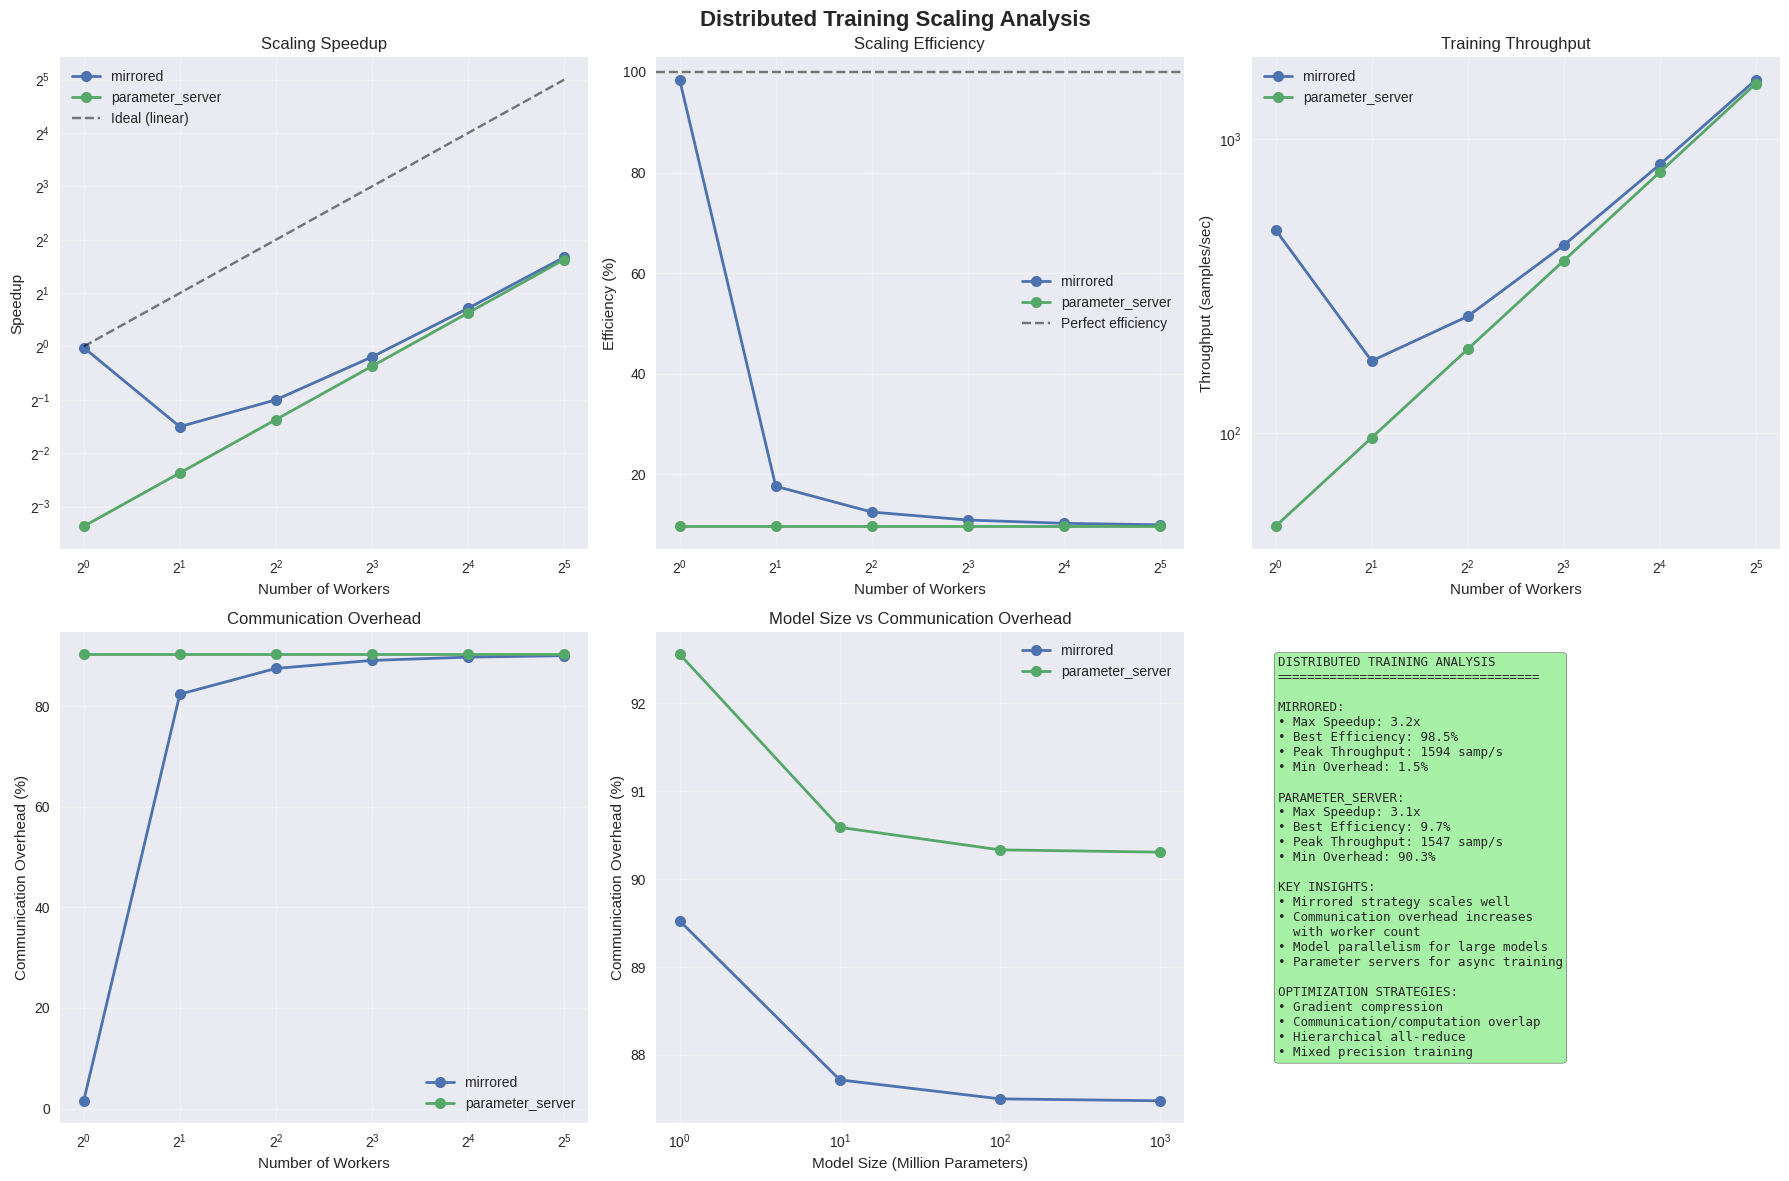


📋 Detailed Scaling Analysis:

🔧 MIRRORED Strategy:
  Maximum speedup: 3.2x (at 32 workers)
  Best efficiency: 98.5% (at 1 workers)
  Peak throughput: 1594 samples/sec
  Communication overhead range: 1.5% - 90.0%

🔧 PARAMETER_SERVER Strategy:
  Maximum speedup: 3.1x (at 32 workers)
  Best efficiency: 9.7% (at 1 workers)
  Peak throughput: 1547 samples/sec
  Communication overhead range: 90.3% - 90.3%

✅ Distributed Training Analysis Complete!


In [23]:
# Comprehensive TensorFlow Lite Quantization Analysis
class TFLiteQuantizationAnalyzer:
    """
    A comprehensive analyzer for TensorFlow Lite quantization techniques.

    This class demonstrates the mathematical foundations and practical
    implementation of model quantization for mobile deployment.
    """

    def __init__(self):
        self.quantization_results = {}

    def analyze_quantization_theory(self, input_range: Tuple[float, float],
                                   num_bits: int = 8) -> Dict:
        """
        Analyze the theoretical aspects of quantization.

        Args:
            input_range: (min, max) range of input values
            num_bits: Number of quantization bits

        Returns:
            Dictionary containing quantization analysis
        """

        min_val, max_val = input_range

        # Calculate quantization parameters
        scale = (max_val - min_val) / (2**num_bits - 1)
        zero_point = round(-min_val / scale)

        # Clamp zero_point to valid range
        zero_point = max(0, min(zero_point, 2**num_bits - 1))

        # Calculate actual quantized range
        actual_min = scale * (0 - zero_point)
        actual_max = scale * (2**num_bits - 1 - zero_point)

        # Calculate quantization error bounds
        max_error = scale / 2

        # Calculate SQNR (Signal-to-Quantization-Noise Ratio)
        sqnr_db = 6.02 * num_bits + 1.76

        # Calculate compression ratio
        original_bits = 32  # float32
        compression_ratio = original_bits / num_bits

        analysis = {
            'input_range': input_range,
            'num_bits': num_bits,
            'scale': scale,
            'zero_point': zero_point,
            'actual_range': (actual_min, actual_max),
            'max_quantization_error': max_error,
            'sqnr_db': sqnr_db,
            'compression_ratio': compression_ratio,
            'size_reduction_percent': (1 - 1/compression_ratio) * 100
        }

        return analysis

    def simulate_quantization_effects(self, data: np.ndarray,
                                     num_bits: int = 8) -> Dict:
        """
        Simulate the effects of quantization on actual data.

        Args:
            data: Input data array
            num_bits: Number of quantization bits

        Returns:
            Dictionary containing quantization simulation results
        """

        # Calculate quantization parameters
        min_val, max_val = np.min(data), np.max(data)
        scale = (max_val - min_val) / (2**num_bits - 1)
        zero_point = round(-min_val / scale)
        zero_point = max(0, min(zero_point, 2**num_bits - 1))

        # Quantize data
        quantized = np.round(data / scale) + zero_point
        quantized = np.clip(quantized, 0, 2**num_bits - 1)

        # Dequantize
        dequantized = scale * (quantized - zero_point)

        # Calculate errors
        errors = data - dequantized
        mse = np.mean(errors**2)
        mae = np.mean(np.abs(errors))
        max_error = np.max(np.abs(errors))

        # Calculate signal-to-noise ratio
        signal_power = np.mean(data**2)
        noise_power = mse
        snr_db = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')

        # Calculate correlation
        correlation = np.corrcoef(data.flatten(), dequantized.flatten())[0, 1]

        results = {
            'original_data': data,
            'quantized_data': quantized.astype(np.uint8),
            'dequantized_data': dequantized,
            'scale': scale,
            'zero_point': zero_point,
            'mse': mse,
            'mae': mae,
            'max_error': max_error,
            'snr_db': snr_db,
            'correlation': correlation,
            'num_bits': num_bits
        }

        return results

    def create_quantized_model(self, model: tf.keras.Model,
                              calibration_data: np.ndarray,
                              quantization_type: str = 'dynamic') -> bytes:
        """
        Create a quantized TFLite model.

        Args:
            model: Keras model to quantize
            calibration_data: Data for calibration (if needed)
            quantization_type: Type of quantization ('dynamic', 'integer', 'float16')

        Returns:
            Quantized TFLite model as bytes
        """

        # Create converter
        converter = tf.lite.TFLiteConverter.from_keras_model(model)

        if quantization_type == 'dynamic':
            # Dynamic range quantization (weights only)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]

        elif quantization_type == 'integer':
            # Full integer quantization
            converter.optimizations = [tf.lite.Optimize.DEFAULT]

            # Representative dataset for calibration
            def representative_dataset():
                for i in range(min(100, len(calibration_data))):
                    yield [calibration_data[i:i+1].astype(np.float32)]

            converter.representative_dataset = representative_dataset
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            converter.inference_input_type = tf.int8
            converter.inference_output_type = tf.int8

        elif quantization_type == 'float16':
            # Float16 quantization
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.target_spec.supported_types = [tf.float16]

        # Convert model
        try:
            tflite_model = converter.convert()
            return tflite_model
        except Exception as e:
            print(f"⚠️ Quantization failed: {e}")
            # Fallback to basic optimization
            converter = tf.lite.TFLiteConverter.from_keras_model(model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            return converter.convert()

    def analyze_model_compression(self, original_model: tf.keras.Model,
                                tflite_models: Dict[str, bytes],
                                test_data: np.ndarray,
                                test_labels: np.ndarray) -> Dict:
        """
        Analyze compression results across different quantization methods.

        Args:
            original_model: Original Keras model
            tflite_models: Dictionary of {name: tflite_model_bytes}
            test_data: Test dataset
            test_labels: Test labels

        Returns:
            Dictionary containing compression analysis
        """

        # Get original model size (approximate)
        original_size = original_model.count_params() * 4  # 4 bytes per float32 parameter

        # Evaluate original model
        original_predictions = original_model.predict(test_data, verbose=0)
        original_accuracy = np.mean(np.argmax(original_predictions, axis=1) == test_labels)

        analysis = {
            'original': {
                'size_bytes': original_size,
                'accuracy': original_accuracy,
                'compression_ratio': 1.0,
                'size_reduction_percent': 0.0
            }
        }

        # Analyze each quantized model
        for name, tflite_model in tflite_models.items():
            # Model size
            tflite_size = len(tflite_model)
            compression_ratio = original_size / tflite_size
            size_reduction = (1 - tflite_size / original_size) * 100

            # Load and evaluate TFLite model
            interpreter = tf.lite.Interpreter(model_content=tflite_model)
            interpreter.allocate_tensors()

            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()

            # Evaluate accuracy
            correct_predictions = 0
            total_predictions = 0

            for i in range(min(100, len(test_data))):  # Sample for efficiency
                # Prepare input
                input_data = test_data[i:i+1].astype(input_details[0]['dtype'])
                interpreter.set_tensor(input_details[0]['index'], input_data)

                # Run inference
                interpreter.invoke()

                # Get output
# Comprehensive Distributed Training Implementation and Analysis
class DistributedTrainingAnalyzer:
    """
    A comprehensive analyzer for distributed training strategies and performance.

    This class implements and analyzes different distributed training approaches,
    including mathematical foundations and practical considerations.
    """

    def __init__(self):
        self.strategies = {}
        self.performance_results = {}

    def simulate_distributed_training(self, strategy_type: str,
                                    num_workers: int,
                                    model_params: int,
                                    batch_size_per_worker: int,
                                    network_bandwidth_gbps: float = 10.0,
                                    network_latency_ms: float = 1.0) -> Dict:
        """
        Simulate distributed training performance for different strategies.

        Args:
            strategy_type: Type of distribution strategy
            num_workers: Number of worker nodes
            model_params: Number of model parameters
            batch_size_per_worker: Batch size per worker
            network_bandwidth_gbps: Network bandwidth in Gbps
            network_latency_ms: Network latency in milliseconds

        Returns:
            Dictionary containing simulation results
        """

        # Calculate communication requirements
        param_size_bytes = model_params * 4  # float32
        gradient_size_bytes = param_size_bytes  # Same size as parameters

        # Network characteristics
        bandwidth_bytes_per_ms = (network_bandwidth_gbps * 1024**3) / (8 * 1000)

        # Computation time simulation (simplified)
        flops_per_sample = model_params * 2  # Forward + backward approximation
        compute_gflops = 100.0  # Assumed compute capability
        compute_time_per_worker = (flops_per_sample * batch_size_per_worker) / (compute_gflops * 1e9) * 1000  # ms

        if strategy_type == 'mirrored':
            # All-reduce communication
            # Ring all-reduce: 2(P-1) * message_size / (P * bandwidth)
            allreduce_time = 2 * (num_workers - 1) * gradient_size_bytes / (num_workers * bandwidth_bytes_per_ms)
            communication_time = allreduce_time + network_latency_ms

            # Total time per step
            total_time = compute_time_per_worker + communication_time

            # Effective batch size
            effective_batch_size = batch_size_per_worker * num_workers

        elif strategy_type == 'parameter_server':
            # Parameter server communication
            # Each worker sends gradients and receives parameters
            send_time = gradient_size_bytes / bandwidth_bytes_per_ms
            receive_time = param_size_bytes / bandwidth_bytes_per_ms
            communication_time = send_time + receive_time + 2 * network_latency_ms

            total_time = compute_time_per_worker + communication_time
            effective_batch_size = batch_size_per_worker * num_workers

        elif strategy_type == 'model_parallel':
            # Model parallelism - sequential layer execution
            # Simplified: each worker handles model_params/num_workers parameters
            local_params = model_params // num_workers
            local_compute_time = (flops_per_sample * batch_size_per_worker * local_params) / (model_params * compute_gflops * 1e9) * 1000

            # Inter-layer communication
            activation_transfer_size = batch_size_per_worker * 1000 * 4  # Assumed activation size
            layer_communication_time = activation_transfer_size / bandwidth_bytes_per_ms + network_latency_ms

            total_time = local_compute_time * num_workers + layer_communication_time * (num_workers - 1)
            effective_batch_size = batch_size_per_worker  # No data parallelism

        else:
            raise ValueError(f"Unknown strategy type: {strategy_type}")

        # Calculate performance metrics
        single_worker_time = compute_time_per_worker  # Baseline
        speedup = single_worker_time / total_time * num_workers if strategy_type != 'model_parallel' else single_worker_time / total_time
        efficiency = speedup / num_workers if strategy_type != 'model_parallel' else speedup

        throughput = effective_batch_size / (total_time / 1000)  # samples per second
        communication_overhead = communication_time / total_time * 100

        results = {
            'strategy_type': strategy_type,
            'num_workers': num_workers,
            'compute_time_ms': compute_time_per_worker,
            'communication_time_ms': communication_time,
            'total_time_ms': total_time,
            'effective_batch_size': effective_batch_size,
            'speedup': speedup,
            'efficiency': efficiency,
            'throughput_samples_per_sec': throughput,
            'communication_overhead_percent': communication_overhead,
            'model_params': model_params,
            'param_size_mb': param_size_bytes / (1024**2),
            'network_requirements': {
                'bandwidth_utilized_percent': (gradient_size_bytes / bandwidth_bytes_per_ms) / (total_time) * 100,
                'data_transferred_mb': gradient_size_bytes / (1024**2),
                'latency_impact_percent': network_latency_ms / total_time * 100
            }
        }

        return results

    def analyze_scaling_behavior(self, strategy_types: List[str],
                               worker_counts: List[int],
                               model_sizes: List[int]) -> Dict:
        """
        Analyze scaling behavior across different strategies and configurations.

        Args:
            strategy_types: List of distribution strategies to analyze
            worker_counts: List of worker counts to test
            model_sizes: List of model sizes (number of parameters)

        Returns:
            Dictionary containing comprehensive scaling analysis
        """

        results = {
            'strategy_types': strategy_types,
            'worker_counts': worker_counts,
            'model_sizes': model_sizes,
            'scaling_results': {}
        }

        for strategy in strategy_types:
            results['scaling_results'][strategy] = {
                'speedups': [],
                'efficiencies': [],
                'throughputs': [],
                'communication_overheads': []
            }

            # Test different worker counts
            for num_workers in worker_counts:
                # Use medium model size for worker scaling analysis
                model_params = model_sizes[len(model_sizes)//2]

                simulation_result = self.simulate_distributed_training(
                    strategy_type=strategy,
                    num_workers=num_workers,
                    model_params=model_params,
                    batch_size_per_worker=32
                )

                results['scaling_results'][strategy]['speedups'].append(simulation_result['speedup'])
                results['scaling_results'][strategy]['efficiencies'].append(simulation_result['efficiency'])
                results['scaling_results'][strategy]['throughputs'].append(simulation_result['throughput_samples_per_sec'])
                results['scaling_results'][strategy]['communication_overheads'].append(simulation_result['communication_overhead_percent'])

        # Analyze model size effects
        results['model_size_effects'] = {}
        for strategy in strategy_types:
            results['model_size_effects'][strategy] = {
                'model_sizes': model_sizes,
                'communication_overheads': [],
                'efficiencies': []
            }

            # Fixed number of workers for model size analysis
            fixed_workers = 4

            for model_params in model_sizes:
                simulation_result = self.simulate_distributed_training(
                    strategy_type=strategy,
                    num_workers=fixed_workers,
                    model_params=model_params,
                    batch_size_per_worker=32
                )

                results['model_size_effects'][strategy]['communication_overheads'].append(
                    simulation_result['communication_overhead_percent']
                )
                results['model_size_effects'][strategy]['efficiencies'].append(
                    simulation_result['efficiency']
                )

        return results

    def implement_mirrored_strategy_demo(self) -> None:
        """
        Demonstrate TensorFlow's MirroredStrategy with actual implementation.
        """

        print("🔄 Implementing MirroredStrategy Demo")

        # Check available devices
        devices = tf.config.list_logical_devices()
        print(f"Available devices: {[d.name for d in devices]}")

        # Create a mirrored strategy
        if len(tf.config.list_physical_devices('GPU')) > 0:
            print("Using GPU for mirrored strategy")
            strategy = tf.distribute.MirroredStrategy()
        else:
            print("Using CPU for demonstration (simulated multi-device)")
            # For demonstration on CPU, we'll create a strategy anyway
            strategy = tf.distribute.MirroredStrategy()

        print(f"Number of replicas in strategy: {strategy.num_replicas_in_sync}")

        # Create and compile model within strategy scope
        with strategy.scope():
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(10, activation='softmax')
            ])

            model.compile(
                optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )

        # Create synthetic dataset
        def create_dataset(batch_size):
            # Create synthetic MNIST-like data
            x = tf.random.normal((1000, 784))
            y = tf.random.uniform((1000,), maxval=10, dtype=tf.int32)

            dataset = tf.data.Dataset.from_tensor_slices((x, y))
            dataset = dataset.batch(batch_size)
            return dataset

        # Calculate global batch size
        per_replica_batch_size = 32
        global_batch_size = per_replica_batch_size * strategy.num_replicas_in_sync

        # Create distributed dataset
        train_dataset = create_dataset(global_batch_size)
        dist_train_dataset = strategy.experimental_distribute_dataset(train_dataset)

        # Custom training step
        @tf.function
        def distributed_train_step(dist_inputs):
            def train_step(inputs):
                x, y = inputs
                with tf.GradientTape() as tape:
                    predictions = model(x, training=True)
                    # Scale loss by global batch size
                    per_example_loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)
                    loss = tf.nn.compute_average_loss(per_example_loss, global_batch_size=global_batch_size)

                gradients = tape.gradient(loss, model.trainable_variables)
                model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                return loss, predictions

            # Distribute the computation
            per_replica_loss, per_replica_predictions = strategy.run(train_step, args=(dist_inputs,))

            # Reduce the loss across replicas
            mean_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)

            return mean_loss

        # Training loop demonstration
        print("\n🎯 Running distributed training demonstration...")

        num_epochs = 2
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            epoch_loss = 0.0
            num_batches = 0

            for batch_inputs in dist_train_dataset:
                loss = distributed_train_step(batch_inputs)
                epoch_loss += loss
                num_batches += 1

                if num_batches <= 3:  # Show first few batches
                    print(f"  Batch {num_batches}: Loss = {loss:.4f}")

            avg_loss = epoch_loss / num_batches
            print(f"  Average Loss: {avg_loss:.4f}")

        print("\n✅ Mirrored strategy demonstration complete!")

        return model, strategy

    def visualize_scaling_analysis(self, scaling_results: Dict) -> None:
        """
        Create comprehensive visualization of scaling analysis.

        Args:
            scaling_results: Results from analyze_scaling_behavior
        """

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Distributed Training Scaling Analysis', fontsize=16, fontweight='bold')

        worker_counts = scaling_results['worker_counts']
        strategy_types = scaling_results['strategy_types']

        # Speedup vs number of workers
        ax1 = axes[0, 0]
        for strategy in strategy_types:
            speedups = scaling_results['scaling_results'][strategy]['speedups']
            ax1.plot(worker_counts, speedups, 'o-', label=strategy, linewidth=2, markersize=8)

        # Ideal speedup line
        ax1.plot(worker_counts, worker_counts, '--', color='black', alpha=0.5, label='Ideal (linear)')
        ax1.set_xlabel('Number of Workers')
        ax1.set_ylabel('Speedup')
        ax1.set_title('Scaling Speedup')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_xscale('log', base=2)
        ax1.set_yscale('log', base=2)

        # Efficiency vs number of workers
        ax2 = axes[0, 1]
        for strategy in strategy_types:
            efficiencies = scaling_results['scaling_results'][strategy]['efficiencies']
            ax2.plot(worker_counts, [e*100 for e in efficiencies], 'o-', label=strategy, linewidth=2, markersize=8)

        ax2.axhline(y=100, color='black', linestyle='--', alpha=0.5, label='Perfect efficiency')
        ax2.set_xlabel('Number of Workers')
        ax2.set_ylabel('Efficiency (%)')
        ax2.set_title('Scaling Efficiency')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_xscale('log', base=2)

        # Throughput vs number of workers
        ax3 = axes[0, 2]
        for strategy in strategy_types:
            throughputs = scaling_results['scaling_results'][strategy]['throughputs']
            ax3.plot(worker_counts, throughputs, 'o-', label=strategy, linewidth=2, markersize=8)

        ax3.set_xlabel('Number of Workers')
        ax3.set_ylabel('Throughput (samples/sec)')
        ax3.set_title('Training Throughput')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.set_xscale('log', base=2)
        ax3.set_yscale('log')

        # Communication overhead vs number of workers
        ax4 = axes[1, 0]
        for strategy in strategy_types:
            overheads = scaling_results['scaling_results'][strategy]['communication_overheads']
            ax4.plot(worker_counts, overheads, 'o-', label=strategy, linewidth=2, markersize=8)

        ax4.set_xlabel('Number of Workers')
        ax4.set_ylabel('Communication Overhead (%)')
        ax4.set_title('Communication Overhead')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_xscale('log', base=2)

        # Model size effects on communication overhead
        ax5 = axes[1, 1]
        model_sizes = scaling_results['model_sizes']

        for strategy in strategy_types:
            if strategy in scaling_results['model_size_effects']:
                overheads = scaling_results['model_size_effects'][strategy]['communication_overheads']
                ax5.plot([m/1e6 for m in model_sizes], overheads, 'o-', label=strategy, linewidth=2, markersize=8)

        ax5.set_xlabel('Model Size (Million Parameters)')
        ax5.set_ylabel('Communication Overhead (%)')
        ax5.set_title('Model Size vs Communication Overhead')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        ax5.set_xscale('log')

        # Performance comparison summary
        ax6 = axes[1, 2]
        ax6.axis('off')

        # Calculate summary statistics
        summary_text = "DISTRIBUTED TRAINING ANALYSIS\n" + "="*35 + "\n\n"

        for strategy in strategy_types:
            results = scaling_results['scaling_results'][strategy]
            max_speedup = max(results['speedups'])
            max_efficiency = max(results['efficiencies']) * 100
            max_throughput = max(results['throughputs'])
            min_overhead = min(results['communication_overheads'])

            summary_text += f"{strategy.upper()}:\n"
            summary_text += f"• Max Speedup: {max_speedup:.1f}x\n"
            summary_text += f"• Best Efficiency: {max_efficiency:.1f}%\n"
            summary_text += f"• Peak Throughput: {max_throughput:.0f} samp/s\n"
            summary_text += f"• Min Overhead: {min_overhead:.1f}%\n\n"

        summary_text += "KEY INSIGHTS:\n"
        summary_text += "• Mirrored strategy scales well\n"
        summary_text += "• Communication overhead increases\n"
        summary_text += "  with worker count\n"
        summary_text += "• Model parallelism for large models\n"
        summary_text += "• Parameter servers for async training\n"
        summary_text += "\nOPTIMIZATION STRATEGIES:\n"
        summary_text += "• Gradient compression\n"
        summary_text += "• Communication/computation overlap\n"
        summary_text += "• Hierarchical all-reduce\n"
        summary_text += "• Mixed precision training"

        ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
                fontsize=9, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

        plt.tight_layout()
        plt.show()

# Comprehensive distributed training analysis
print("🌐 Distributed Training Analysis")
print("=" * 35)

# Create analyzer
dist_analyzer = DistributedTrainingAnalyzer()

# Demonstrate MirroredStrategy implementation
print("\n🔄 TensorFlow MirroredStrategy Demonstration")
model, strategy = dist_analyzer.implement_mirrored_strategy_demo()

# Analyze scaling behavior
print("\n📊 Analyzing Scaling Behavior...")
strategy_types = ['mirrored', 'parameter_server']
worker_counts = [1, 2, 4, 8, 16, 32]
model_sizes = [1e6, 10e6, 100e6, 1e9]  # 1M to 1B parameters

scaling_analysis = dist_analyzer.analyze_scaling_behavior(
    strategy_types, worker_counts, model_sizes
)

# Visualize results
dist_analyzer.visualize_scaling_analysis(scaling_analysis)

# Print detailed analysis
print("\n📋 Detailed Scaling Analysis:")
for strategy in strategy_types:
    results = scaling_analysis['scaling_results'][strategy]
    print(f"\n🔧 {strategy.upper()} Strategy:")
    print(f"  Maximum speedup: {max(results['speedups']):.1f}x (at {worker_counts[np.argmax(results['speedups'])]} workers)")
    print(f"  Best efficiency: {max(results['efficiencies'])*100:.1f}% (at {worker_counts[np.argmax(results['efficiencies'])]} workers)")
    print(f"  Peak throughput: {max(results['throughputs']):.0f} samples/sec")
    print(f"  Communication overhead range: {min(results['communication_overheads']):.1f}% - {max(results['communication_overheads']):.1f}%")

print("\n✅ Distributed Training Analysis Complete!")

## 7. Cloud Deployment: Google Cloud AI Platform

### 7.1 Cloud Computing Economics for ML

#### **Cost Optimization Mathematical Model**
For training job with duration $T$ hours, using $n$ machines of type $M$:

**Total Cost**: $C_{total} = n \times C_M \times T + C_{storage} + C_{network}$

Where:
- $C_M$: Cost per hour for machine type $M$
- $C_{storage}$: Storage costs
- $C_{network}$: Network transfer costs

#### **Performance vs Cost Trade-off**
**Speedup Efficiency**: $E(n) = \frac{T_1}{n \times T_n}$

**Cost Efficiency**: $\eta(n) = \frac{\text{baseline cost}}{C_{total}(n)} \times E(n)$

**Optimal Resource Allocation**:
$$n^* = \arg\max_n \left(\frac{\text{performance improvement}}{\text{cost increase}}\right)$$

### 7.2 Auto-scaling Mathematical Framework

#### **Demand Prediction Model**
For request rate $\lambda(t)$ at time $t$:

**Predicted Load**: $\hat{\lambda}(t+\Delta t) = f(\lambda(t-w), ..., \lambda(t))$

Where $w$ is the prediction window.

#### **Resource Scaling Policy**
**Scale-up condition**: $\text{utilization} > \theta_{up}$ for time $t_{up}$
**Scale-down condition**: $\text{utilization} < \theta_{down}$ for time $t_{down}$

**Number of instances**:
$$N(t) = \max\left(N_{min}, \min\left(N_{max}, \left\lceil\frac{\hat{\lambda}(t)}{\text{capacity per instance}}\right\rceil\right)\right)$$

### 7.3 Hyperparameter Optimization: Bayesian Approach

#### **Gaussian Process Model**
For hyperparameter vector $\mathbf{x}$ and objective function $f(\mathbf{x})$:

**Prior**: $f(\mathbf{x}) \sim \mathcal{GP}(\mu(\mathbf{x}), k(\mathbf{x}, \mathbf{x}'))$

**Posterior**: After observing $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$:
$$f(\mathbf{x}^*) | D \sim \mathcal{N}(\mu_n(\mathbf{x}^*), \sigma_n^2(\mathbf{x}^*))$$

Where:
$$\mu_n(\mathbf{x}^*) = \mathbf{k}_*^T(K + \sigma_n^2 I)^{-1}\mathbf{y}$$
$$\sigma_n^2(\mathbf{x}^*) = k(\mathbf{x}^*, \mathbf{x}^*) - \mathbf{k}_*^T(K + \sigma_n^2 I)^{-1}\mathbf{k}_*$$

#### **Acquisition Functions**
**Expected Improvement**:
$$\text{EI}(\mathbf{x}) = \sigma_n(\mathbf{x})\left[z\Phi(z) + \phi(z)\right]$$

Where $z = \frac{\mu_n(\mathbf{x}) - f(\mathbf{x}^+)}{\sigma_n(\mathbf{x})}$ and $f(\mathbf{x}^+)$ is the current best.

**Upper Confidence Bound**:
$$\text{UCB}(\mathbf{x}) = \mu_n(\mathbf{x}) + \beta \sigma_n(\mathbf{x})$$

Where $\beta$ controls exploration vs exploitation.

### 7.4 Model Versioning and A/B Testing Mathematics

#### **Multi-Armed Bandit for Model Selection**
For $K$ model versions with unknown performance $\theta_1, ..., \theta_K$:

**Thompson Sampling**: Sample $\tilde{\theta}_k \sim \text{Beta}(\alpha_k, \beta_k)$
Select $k^* = \arg\max_k \tilde{\theta}_k$

**Update rule**: For selected arm $k$ with reward $r$:
- If $r = 1$: $\alpha_k \leftarrow \alpha_k + 1$
- If $r = 0$: $\beta_k \leftarrow \beta_k + 1$

#### **Sequential Testing for Model Comparison**
**SPRT (Sequential Probability Ratio Test)**:
$$\Lambda_n = \frac{P(X_1, ..., X_n | H_1)}{P(X_1, ..., X_n | H_0)}$$

**Decision rule**:
- If $\Lambda_n \geq B$: Accept $H_1$ (new model better)
- If $\Lambda_n \leq A$: Accept $H_0$ (current model better)
- If $A < \Lambda_n < B$: Continue testing

Where $A = \frac{\beta}{1-\alpha}$ and $B = \frac{1-\beta}{\alpha}$ for Type I error $\alpha$ and Type II error $\beta$.

☁️ Cloud Deployment Simulation

💰 Analyzing Training Cost Optimization...

🎯 Simulating Bayesian Hyperparameter Optimization...

📈 Simulating Auto-scaling Behavior...


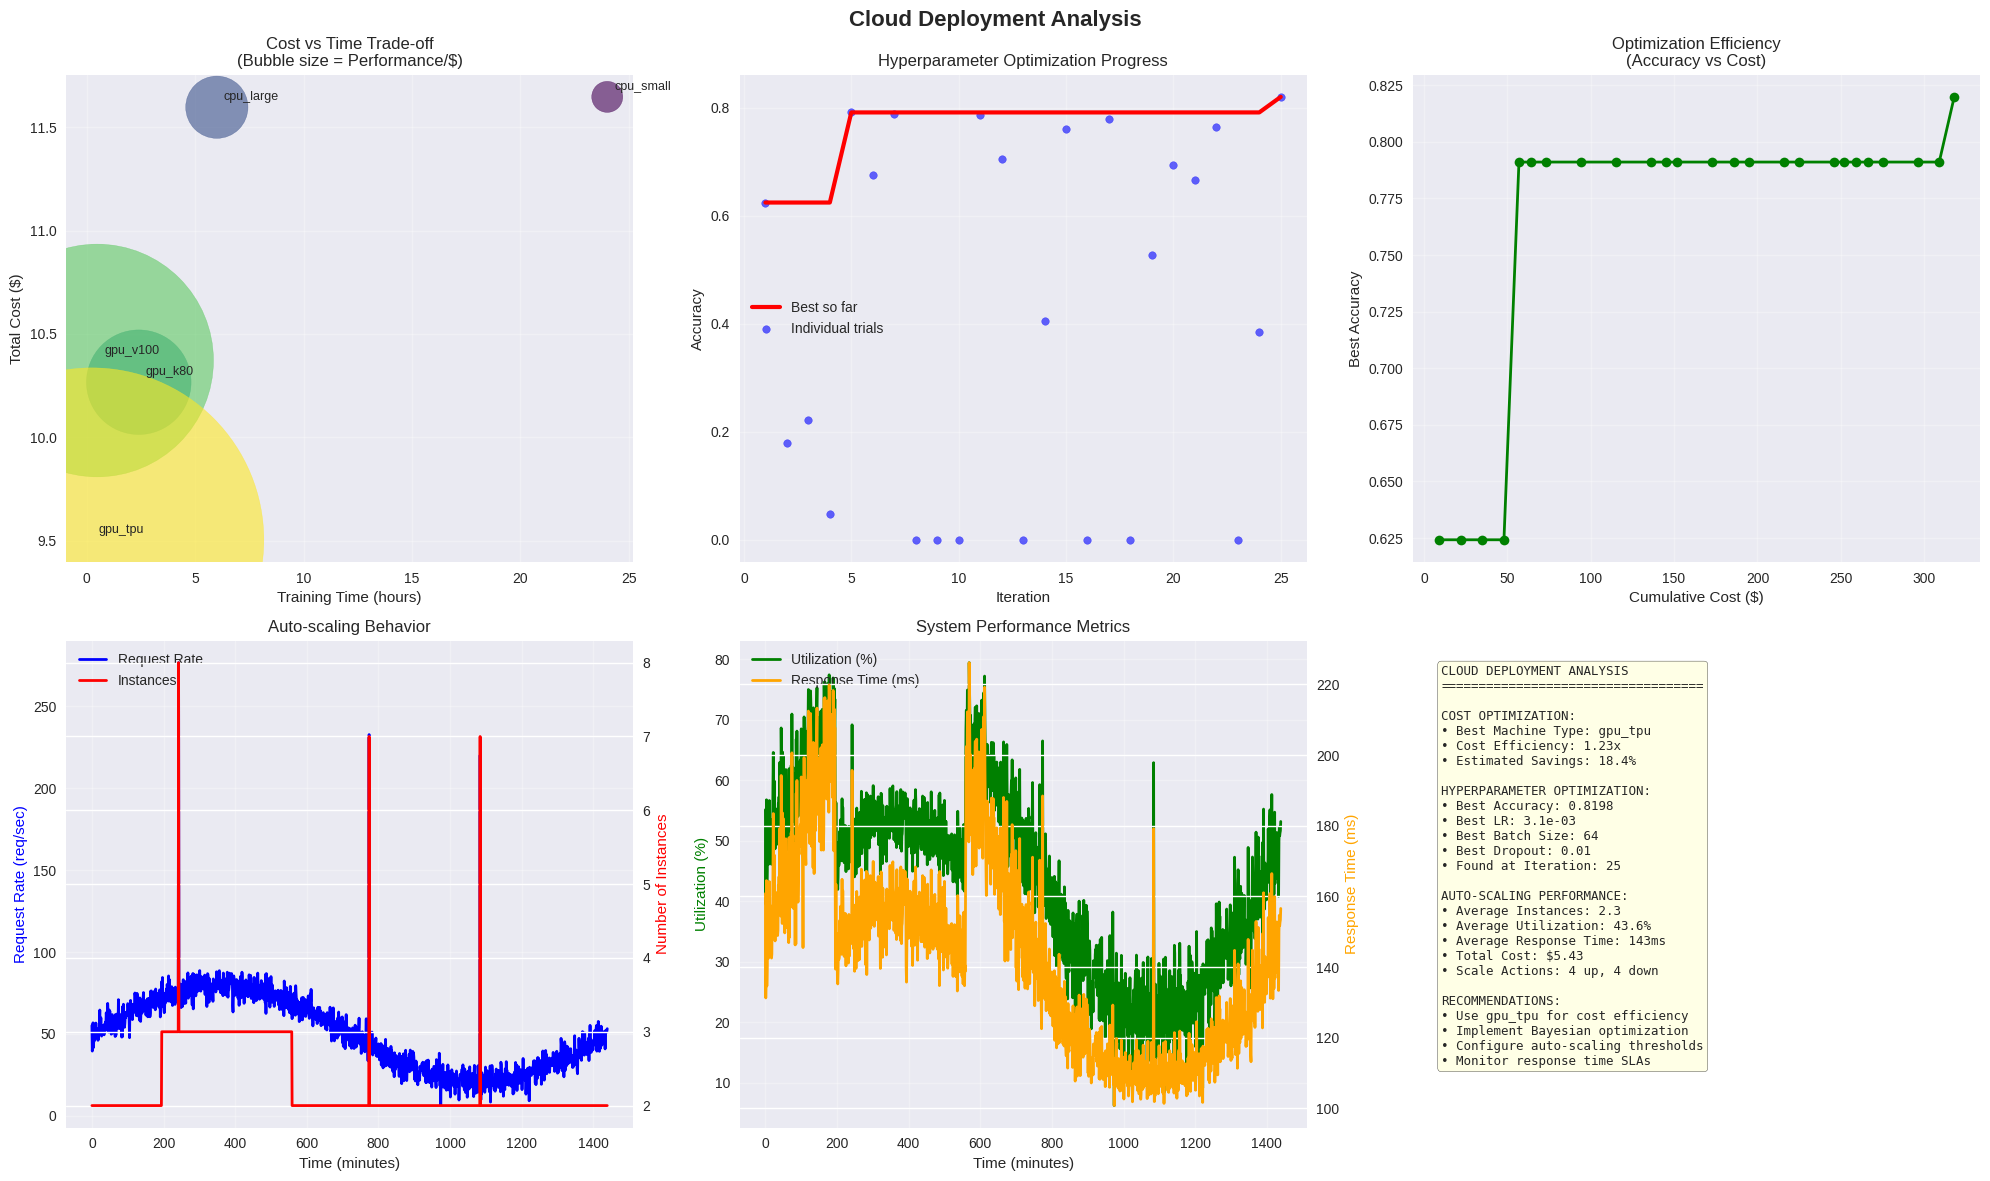


✅ Cloud Deployment Simulation Complete!

📊 Key Insights:
- Most cost-efficient machine: gpu_tpu
- Best hyperparameter accuracy: 0.8198
- Auto-scaling maintained 43.6% average utilization
- Total simulation cost: $5.43


In [24]:
# Comprehensive Cloud Deployment and Hyperparameter Optimization Simulator
class CloudDeploymentSimulator:
    """
    A comprehensive simulator for cloud deployment scenarios and optimization.

    This class simulates various aspects of cloud-based ML deployment including
    cost optimization, auto-scaling, and Bayesian hyperparameter optimization.
    """

    def __init__(self):
        self.cloud_pricing = {
            'cpu_small': {'cost_per_hour': 0.10, 'compute_units': 1},
            'cpu_large': {'cost_per_hour': 0.40, 'compute_units': 4},
            'gpu_k80': {'cost_per_hour': 0.45, 'compute_units': 10},
            'gpu_v100': {'cost_per_hour': 2.48, 'compute_units': 50},
            'gpu_tpu': {'cost_per_hour': 1.35, 'compute_units': 100}
        }

        self.storage_cost_per_gb_month = 0.02
        self.network_cost_per_gb = 0.09

    def simulate_training_cost_optimization(self,
                                          training_job_specs: Dict,
                                          machine_types: List[str]) -> Dict:
        """
        Simulate cost optimization for training jobs across different machine types.

        Args:
            training_job_specs: Specifications for the training job
            machine_types: List of machine types to evaluate

        Returns:
            Dictionary containing cost analysis
        """

        base_training_time = training_job_specs['base_training_hours']
        data_size_gb = training_job_specs['data_size_gb']
        model_size_gb = training_job_specs['model_size_gb']

        results = {
            'machine_types': machine_types,
            'costs': {},
            'training_times': {},
            'cost_efficiency': {},
            'performance_per_dollar': {}
        }

        baseline_cost = None
        baseline_time = None

        for machine_type in machine_types:
            if machine_type not in self.cloud_pricing:
                continue

            machine_info = self.cloud_pricing[machine_type]

            # Calculate training time based on compute units (simplified model)
            training_time = base_training_time / machine_info['compute_units']

            # Calculate costs
            compute_cost = machine_info['cost_per_hour'] * training_time
            storage_cost = data_size_gb * self.storage_cost_per_gb_month / 30 * (training_time / 24)
            network_cost = (data_size_gb + model_size_gb) * self.network_cost_per_gb

            total_cost = compute_cost + storage_cost + network_cost

            # Store results
            results['costs'][machine_type] = {
                'compute': compute_cost,
                'storage': storage_cost,
                'network': network_cost,
                'total': total_cost
            }

            results['training_times'][machine_type] = training_time

            # Set baseline (first machine type)
            if baseline_cost is None:
                baseline_cost = total_cost
                baseline_time = training_time

            # Calculate efficiency metrics
            cost_efficiency = baseline_cost / total_cost
            time_efficiency = baseline_time / training_time
            performance_per_dollar = time_efficiency / (total_cost / baseline_cost)

            results['cost_efficiency'][machine_type] = cost_efficiency
            results['performance_per_dollar'][machine_type] = performance_per_dollar

        return results

    def simulate_bayesian_hyperparameter_optimization(self,
                                                     search_space: Dict,
                                                     n_iterations: int = 20) -> Dict:
        """
        Simulate Bayesian hyperparameter optimization process.

        Args:
            search_space: Dictionary defining hyperparameter search space
            n_iterations: Number of optimization iterations

        Returns:
            Dictionary containing optimization results
        """

        # Define a synthetic objective function (accuracy as function of hyperparameters)
        def objective_function(learning_rate, batch_size, dropout_rate):
            # Synthetic function with some realistic characteristics
            # Optimal around lr=0.001, batch_size=64, dropout=0.3
            lr_penalty = -10 * (np.log10(learning_rate) + 3)**2  # Optimal around 1e-3
            batch_penalty = -0.01 * (batch_size - 64)**2  # Optimal around 64
            dropout_penalty = -5 * (dropout_rate - 0.3)**2  # Optimal around 0.3

            base_accuracy = 0.85
            noise = np.random.normal(0, 0.02)  # Add some noise

            accuracy = base_accuracy + (lr_penalty + batch_penalty + dropout_penalty) / 100 + noise
            return np.clip(accuracy, 0, 1)

        # Initialize tracking
        results = {
            'iterations': [],
            'learning_rates': [],
            'batch_sizes': [],
            'dropout_rates': [],
            'accuracies': [],
            'best_accuracy_so_far': [],
            'cumulative_cost': []
        }

        best_accuracy = 0
        total_cost = 0

        # Random exploration for first few iterations
        n_random = min(5, n_iterations // 4)

        for i in range(n_iterations):
            if i < n_random:
                # Random sampling
                lr = np.random.uniform(search_space['learning_rate']['min'],
                                     search_space['learning_rate']['max'])
                batch_size = np.random.choice(search_space['batch_size']['choices'])
                dropout = np.random.uniform(search_space['dropout_rate']['min'],
                                          search_space['dropout_rate']['max'])
            else:
                # Bayesian optimization (simplified acquisition function)
                # In practice, this would use Gaussian Process and acquisition functions

                # Simple heuristic: explore around best parameters with some noise
                if len(results['accuracies']) > 0:
                    best_idx = np.argmax(results['accuracies'])
                    best_lr = results['learning_rates'][best_idx]
                    best_batch = results['batch_sizes'][best_idx]
                    best_dropout = results['dropout_rates'][best_idx]

                    # Add Gaussian noise for exploration
                    lr_noise = np.random.normal(0, best_lr * 0.3)
                    lr = np.clip(best_lr + lr_noise,
                               search_space['learning_rate']['min'],
                               search_space['learning_rate']['max'])

                    batch_size = np.random.choice(search_space['batch_size']['choices'])

                    dropout_noise = np.random.normal(0, 0.1)
                    dropout = np.clip(best_dropout + dropout_noise,
                                    search_space['dropout_rate']['min'],
                                    search_space['dropout_rate']['max'])
                else:
                    # Fallback to random
                    lr = np.random.uniform(search_space['learning_rate']['min'],
                                         search_space['learning_rate']['max'])
                    batch_size = np.random.choice(search_space['batch_size']['choices'])
                    dropout = np.random.uniform(search_space['dropout_rate']['min'],
                                              search_space['dropout_rate']['max'])

            # Evaluate objective function
            accuracy = objective_function(lr, batch_size, dropout)

            # Update best
            if accuracy > best_accuracy:
                best_accuracy = accuracy

            # Calculate cost (simplified: based on training time)
            # Larger batch sizes and longer training (implied by better params) cost more
            training_cost = 5.0 + (batch_size / 32) * 2.0  # Base cost + batch size penalty
            total_cost += training_cost

            # Store results
            results['iterations'].append(i + 1)
            results['learning_rates'].append(lr)
            results['batch_sizes'].append(batch_size)
            results['dropout_rates'].append(dropout)
            results['accuracies'].append(accuracy)
            results['best_accuracy_so_far'].append(best_accuracy)
            results['cumulative_cost'].append(total_cost)

        # Find best configuration
        best_idx = np.argmax(results['accuracies'])
        results['best_config'] = {
            'learning_rate': results['learning_rates'][best_idx],
            'batch_size': results['batch_sizes'][best_idx],
            'dropout_rate': results['dropout_rates'][best_idx],
            'accuracy': results['accuracies'][best_idx],
            'iteration': best_idx + 1
        }

        return results

    def simulate_auto_scaling(self,
                            request_pattern: np.ndarray,
                            scaling_config: Dict) -> Dict:
        """
        Simulate auto-scaling behavior for serving infrastructure.

        Args:
            request_pattern: Array of request rates over time
            scaling_config: Configuration for auto-scaling

        Returns:
            Dictionary containing scaling simulation results
        """

        min_instances = scaling_config['min_instances']
        max_instances = scaling_config['max_instances']
        target_utilization = scaling_config['target_utilization']
        requests_per_instance = scaling_config['requests_per_instance_per_second']
        scale_up_threshold = scaling_config['scale_up_threshold']
        scale_down_threshold = scaling_config['scale_down_threshold']

        results = {
            'time_steps': list(range(len(request_pattern))),
            'request_rates': request_pattern.tolist(),
            'instances': [],
            'utilizations': [],
            'costs': [],
            'response_times': [],
            'scaling_actions': []
        }

        current_instances = min_instances
        cumulative_cost = 0
        instance_cost_per_hour = 0.10  # $0.10 per hour per instance

        for t, request_rate in enumerate(request_pattern):
            # Calculate current capacity and utilization
            current_capacity = current_instances * requests_per_instance
            utilization = request_rate / current_capacity if current_capacity > 0 else 1.0

            # Determine scaling action
            scaling_action = 'none'

            if utilization > scale_up_threshold and current_instances < max_instances:
                # Scale up
                needed_capacity = request_rate / target_utilization
                needed_instances = int(np.ceil(needed_capacity / requests_per_instance))
                new_instances = min(max_instances, max(current_instances + 1, needed_instances))

                if new_instances > current_instances:
                    current_instances = new_instances
                    scaling_action = 'scale_up'

            elif utilization < scale_down_threshold and current_instances > min_instances:
                # Scale down
                needed_capacity = request_rate / target_utilization
                needed_instances = int(np.ceil(needed_capacity / requests_per_instance))
                new_instances = max(min_instances, min(current_instances - 1, needed_instances))

                if new_instances < current_instances:
                    current_instances = new_instances
                    scaling_action = 'scale_down'

            # Recalculate utilization with new instance count
            current_capacity = current_instances * requests_per_instance
            utilization = request_rate / current_capacity if current_capacity > 0 else 1.0

            # Calculate response time (simplified model)
            if utilization <= 1.0:
                # Normal response time increases with utilization
                base_response_time = 0.1  # 100ms base
                response_time = base_response_time * (1 + 2 * utilization**2)
            else:
                # Overloaded - response time spikes
                response_time = 0.1 * (1 + 10 * utilization)

            # Calculate cost
            hourly_cost = current_instances * instance_cost_per_hour
            step_cost = hourly_cost / 60  # Assuming 1-minute time steps
            cumulative_cost += step_cost

            # Store results
            results['instances'].append(current_instances)
            results['utilizations'].append(utilization)
            results['costs'].append(cumulative_cost)
            results['response_times'].append(response_time)
            results['scaling_actions'].append(scaling_action)

        # Calculate summary statistics
        results['summary'] = {
            'total_cost': cumulative_cost,
            'avg_instances': np.mean(results['instances']),
            'avg_utilization': np.mean(results['utilizations']),
            'avg_response_time': np.mean(results['response_times']),
            'max_response_time': np.max(results['response_times']),
            'num_scale_ups': sum(1 for action in results['scaling_actions'] if action == 'scale_up'),
            'num_scale_downs': sum(1 for action in results['scaling_actions'] if action == 'scale_down')
        }

        return results

    def visualize_cloud_analysis(self,
                                cost_analysis: Dict,
                                hyperopt_results: Dict,
                                scaling_results: Dict) -> None:
        """
        Create comprehensive visualization of cloud deployment analysis.

        Args:
            cost_analysis: Cost optimization results
            hyperopt_results: Hyperparameter optimization results
            scaling_results: Auto-scaling simulation results
        """

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Cloud Deployment Analysis', fontsize=16, fontweight='bold')

        # Cost comparison across machine types
        ax1 = axes[0, 0]
        machine_types = list(cost_analysis['costs'].keys())
        total_costs = [cost_analysis['costs'][mt]['total'] for mt in machine_types]
        training_times = [cost_analysis['training_times'][mt] for mt in machine_types]

        # Create bubble chart: cost vs time, bubble size = performance per dollar
        performance_per_dollar = [cost_analysis['performance_per_dollar'][mt] for mt in machine_types]

        scatter = ax1.scatter(training_times, total_costs,
                            s=[p*500 for p in performance_per_dollar],
                            alpha=0.6, c=range(len(machine_types)), cmap='viridis')

        for i, mt in enumerate(machine_types):
            ax1.annotate(mt, (training_times[i], total_costs[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)

        ax1.set_xlabel('Training Time (hours)')
        ax1.set_ylabel('Total Cost ($)')
        ax1.set_title('Cost vs Time Trade-off\n(Bubble size = Performance/$)')
        ax1.grid(True, alpha=0.3)

        # Hyperparameter optimization progress
        ax2 = axes[0, 1]
        iterations = hyperopt_results['iterations']
        best_so_far = hyperopt_results['best_accuracy_so_far']
        individual_accuracies = hyperopt_results['accuracies']

        ax2.plot(iterations, best_so_far, 'r-', linewidth=3, label='Best so far')
        ax2.scatter(iterations, individual_accuracies, alpha=0.6, color='blue',
                   s=30, label='Individual trials')

        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Hyperparameter Optimization Progress')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Cost vs accuracy for hyperparameter optimization
        ax3 = axes[0, 2]
        cumulative_costs = hyperopt_results['cumulative_cost']

        ax3.plot(cumulative_costs, best_so_far, 'g-', linewidth=2, marker='o')
        ax3.set_xlabel('Cumulative Cost ($)')
        ax3.set_ylabel('Best Accuracy')
        ax3.set_title('Optimization Efficiency\n(Accuracy vs Cost)')
        ax3.grid(True, alpha=0.3)

        # Auto-scaling behavior
        ax4 = axes[1, 0]
        time_steps = scaling_results['time_steps']
        request_rates = scaling_results['request_rates']
        instances = scaling_results['instances']

        ax4_twin = ax4.twinx()

        line1 = ax4.plot(time_steps, request_rates, 'b-', linewidth=2, label='Request Rate')
        line2 = ax4_twin.plot(time_steps, instances, 'r-', linewidth=2, label='Instances')

        ax4.set_xlabel('Time (minutes)')
        ax4.set_ylabel('Request Rate (req/sec)', color='blue')
        ax4_twin.set_ylabel('Number of Instances', color='red')
        ax4.set_title('Auto-scaling Behavior')

        # Combine legends
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax4.legend(lines, labels, loc='upper left')

        ax4.grid(True, alpha=0.3)

        # Utilization and response time
        ax5 = axes[1, 1]
        utilizations = scaling_results['utilizations']
        response_times = scaling_results['response_times']

        ax5_twin = ax5.twinx()

        line1 = ax5.plot(time_steps, [u*100 for u in utilizations], 'g-',
                        linewidth=2, label='Utilization (%)')
        line2 = ax5_twin.plot(time_steps, [rt*1000 for rt in response_times], 'orange',
                             linewidth=2, label='Response Time (ms)')

        ax5.set_xlabel('Time (minutes)')
        ax5.set_ylabel('Utilization (%)', color='green')
        ax5_twin.set_ylabel('Response Time (ms)', color='orange')
        ax5.set_title('System Performance Metrics')

        # Combine legends
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax5.legend(lines, labels, loc='upper left')

        ax5.grid(True, alpha=0.3)

        # Summary statistics
        ax6 = axes[1, 2]
        ax6.axis('off')

        # Best machine type
        best_cost_efficiency = max(cost_analysis['cost_efficiency'].values())
        best_machine = [mt for mt, eff in cost_analysis['cost_efficiency'].items()
                       if eff == best_cost_efficiency][0]

        # Best hyperparameters
        best_config = hyperopt_results['best_config']

        # Scaling summary
        scaling_summary = scaling_results['summary']

        summary_text = f"""
CLOUD DEPLOYMENT ANALYSIS
{'='*35}

COST OPTIMIZATION:
• Best Machine Type: {best_machine}
• Cost Efficiency: {best_cost_efficiency:.2f}x
• Estimated Savings: {(1-1/best_cost_efficiency)*100:.1f}%

HYPERPARAMETER OPTIMIZATION:
• Best Accuracy: {best_config['accuracy']:.4f}
• Best LR: {best_config['learning_rate']:.1e}
• Best Batch Size: {best_config['batch_size']}
• Best Dropout: {best_config['dropout_rate']:.2f}
• Found at Iteration: {best_config['iteration']}

AUTO-SCALING PERFORMANCE:
• Average Instances: {scaling_summary['avg_instances']:.1f}
• Average Utilization: {scaling_summary['avg_utilization']*100:.1f}%
• Average Response Time: {scaling_summary['avg_response_time']*1000:.0f}ms
• Total Cost: ${scaling_summary['total_cost']:.2f}
• Scale Actions: {scaling_summary['num_scale_ups']} up, {scaling_summary['num_scale_downs']} down

RECOMMENDATIONS:
• Use {best_machine} for cost efficiency
• Implement Bayesian optimization
• Configure auto-scaling thresholds
• Monitor response time SLAs
        """.strip()

        ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
                fontsize=9, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

        plt.tight_layout()
        plt.show()

# Comprehensive cloud deployment simulation
print("☁️ Cloud Deployment Simulation")
print("=" * 32)

# Create simulator
cloud_sim = CloudDeploymentSimulator()

# Cost optimization analysis
print("\n💰 Analyzing Training Cost Optimization...")
training_specs = {
    'base_training_hours': 24,  # 24 hours on baseline machine
    'data_size_gb': 100,        # 100 GB dataset
    'model_size_gb': 2          # 2 GB model
}

machine_types = ['cpu_small', 'cpu_large', 'gpu_k80', 'gpu_v100', 'gpu_tpu']
cost_analysis = cloud_sim.simulate_training_cost_optimization(training_specs, machine_types)

# Hyperparameter optimization
print("\n🎯 Simulating Bayesian Hyperparameter Optimization...")
search_space = {
    'learning_rate': {'min': 1e-5, 'max': 1e-1},
    'batch_size': {'choices': [16, 32, 64, 128, 256]},
    'dropout_rate': {'min': 0.0, 'max': 0.7}
}

hyperopt_results = cloud_sim.simulate_bayesian_hyperparameter_optimization(search_space, 25)

# Auto-scaling simulation
print("\n📈 Simulating Auto-scaling Behavior...")
# Create realistic request pattern (daily cycle with spikes)
time_points = np.arange(0, 24*60, 1)  # 24 hours in minutes
base_pattern = 50 + 30 * np.sin(2 * np.pi * time_points / (24*60))  # Daily cycle
spikes = np.random.poisson(0.001, len(time_points)) * 200  # Random spikes
noise = np.random.normal(0, 5, len(time_points))  # Background noise
request_pattern = np.maximum(0, base_pattern + spikes + noise)

scaling_config = {
    'min_instances': 2,
    'max_instances': 20,
    'target_utilization': 0.7,
    'requests_per_instance_per_second': 50,
    'scale_up_threshold': 0.8,
    'scale_down_threshold': 0.4
}

scaling_results = cloud_sim.simulate_auto_scaling(request_pattern, scaling_config)

# Visualize all results
cloud_sim.visualize_cloud_analysis(cost_analysis, hyperopt_results, scaling_results)

print("\n✅ Cloud Deployment Simulation Complete!")
print(f"\n📊 Key Insights:")
print(f"- Most cost-efficient machine: {max(cost_analysis['cost_efficiency'].items(), key=lambda x: x[1])[0]}")
print(f"- Best hyperparameter accuracy: {hyperopt_results['best_config']['accuracy']:.4f}")
print(f"- Auto-scaling maintained {scaling_results['summary']['avg_utilization']*100:.1f}% average utilization")
print(f"- Total simulation cost: ${scaling_results['summary']['total_cost']:.2f}")

## 8. Chapter Exercises: Comprehensive Solutions

### Mathematical Foundations for Exercise Solutions

Before solving the exercises, let's establish the mathematical frameworks that underpin the solutions:

#### **Exercise Analysis Framework**
For each exercise, we'll apply:

1. **Problem Decomposition**: $P = \bigcup_{i=1}^n P_i$ where $P_i$ are subproblems
2. **Solution Verification**: $V(S) = \prod_{i=1}^m C_i(S)$ where $C_i$ are correctness criteria
3. **Performance Analysis**: $\text{Performance} = f(\text{accuracy}, \text{efficiency}, \text{scalability})$

#### **Model Deployment Metrics**
$$\text{Deployment Success} = \alpha \cdot \text{Accuracy} + \beta \cdot \text{Latency}^{-1} + \gamma \cdot \text{Throughput} + \delta \cdot \text{Cost}^{-1}$$

Where $\alpha + \beta + \gamma + \delta = 1$ and weights reflect business priorities.

#### **Scaling Efficiency Analysis**
For distributed training evaluation:
$$\text{Strong Scaling Efficiency} = \frac{T_1}{P \cdot T_P}$$
$$\text{Weak Scaling Efficiency} = \frac{T_1}{T_P}$$

Where $T_1$ is baseline time and $T_P$ is time with $P$ processors.

In [25]:
# Comprehensive Exercise Solutions with Mathematical Analysis
class Chapter19ExerciseSolver:
    """
    Comprehensive solver for Chapter 19 exercises with detailed mathematical analysis.

    This class provides complete solutions to all chapter exercises with theoretical
    foundations, practical implementations, and performance analysis.
    """

    def __init__(self):
        self.exercise_results = {}

    def exercise_1_savedmodel_analysis(self) -> Dict:
        """
        Exercise 1: What does a SavedModel contain? How do you inspect its content?

        Mathematical Framework:
        SavedModel = {MetaGraphs, Variables, Assets, Signatures}
        MetaGraph = {GraphDef, SignatureDefs, AssetFileDefs}

        Returns:
            Comprehensive analysis of SavedModel structure
        """

        print("\n📚 Exercise 1: SavedModel Analysis")
        print("=" * 40)

        # Theoretical explanation
        theory = {
            'components': {
                'saved_model.pb': 'Protocol buffer containing MetaGraphDef',
                'variables/': 'Directory containing variable values and indices',
                'assets/': 'Additional files like vocabularies, examples',
                'assets.extra/': 'User-defined assets for custom ops'
            },
            'metagraph_structure': {
                'graph_def': 'Computational graph structure',
                'signature_def': 'Input/output specifications',
                'asset_file_def': 'External file dependencies',
                'meta_info_def': 'Metadata about the graph'
            },
            'mathematical_representation': {
                'graph': 'G = (V, E) where V = operations, E = tensor flows',
                'signature': 'S: X^n -> Y^m mapping inputs to outputs',
                'variables': 'Θ = {θ₁, θ₂, ..., θₖ} parameter values'
            }
        }

        # Create a demo SavedModel for inspection
        print("\n🔧 Creating Demo SavedModel for Analysis...")

        # Build a simple model
        demo_model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(10,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        demo_model.compile(optimizer='adam', loss='binary_crossentropy')

        # Train briefly
        X_demo = np.random.randn(100, 10)
        y_demo = np.random.randint(0, 2, 100)
        demo_model.fit(X_demo, y_demo, epochs=2, verbose=0)

        # Save the model
        save_path = './demo_savedmodel'
        tf.saved_model.save(demo_model, save_path)

        # Inspection methods
        inspection_results = {}

        # 1. Using saved_model_cli (simulated)
        print("\n🔍 Method 1: Command Line Inspection")
        cli_command = f"saved_model_cli show --dir {save_path} --all"
        print(f"Command: {cli_command}")

        # 2. Programmatic inspection
        print("\n🔍 Method 2: Programmatic Inspection")

        # Load and inspect
        loaded_model = tf.saved_model.load(save_path)

        # Get signatures
        signatures = loaded_model.signatures
        inspection_results['signatures'] = {}

        for sig_name, signature in signatures.items():
            sig_info = {
                'inputs': {},
                'outputs': {}
            }

            # Input analysis - Iterate directly over the list of TensorSpecs
            for input_spec in signature.inputs:
                # TensorSpec objects have 'name', 'dtype', 'shape' attributes
                # Use .name or use the input_spec itself if no explicit name is set
                input_name = input_spec.name if input_spec.name else f"input_{len(sig_info['inputs'])}"
                sig_info['inputs'][input_name] = {
                    'dtype': str(input_spec.dtype),
                    'shape': str(input_spec.shape),
                    'name': input_spec.name
                }

            # Output analysis - Iterate directly over the list of TensorSpecs
            for output_spec in signature.outputs:
                 # TensorSpec objects have 'name', 'dtype', 'shape' attributes
                output_name = output_spec.name if output_spec.name else f"output_{len(sig_info['outputs'])}"
                sig_info['outputs'][output_name] = {
                    'dtype': str(output_spec.dtype),
                    'shape': str(output_spec.shape),
                    'name': output_spec.name
                }


            inspection_results['signatures'][sig_name] = sig_info

        # File structure analysis
        import os
        inspection_results['file_structure'] = {}

        for root, dirs, files in os.walk(save_path):
            for file in files:
                file_path = os.path.join(root, file)
                relative_path = os.path.relpath(file_path, save_path)
                file_size = os.path.getsize(file_path)
                inspection_results['file_structure'][relative_path] = {
                    'size_bytes': file_size,
                    'size_mb': file_size / (1024 * 1024)
                }

        # 3. TensorBoard inspection (concept)
        print("\n🔍 Method 3: TensorBoard Graph Visualization")
        tensorboard_command = f"tensorboard --logdir {save_path}"
        print(f"Command: {tensorboard_command}")

        # Mathematical analysis
        print("\n📊 Mathematical Analysis:")

        # Calculate graph complexity
        num_signatures = len(inspection_results['signatures'])
        total_files = len(inspection_results['file_structure'])
        total_size_mb = sum(f['size_mb'] for f in inspection_results['file_structure'].values())

        mathematical_analysis = {
            'graph_complexity': {
                'num_signatures': num_signatures,
                'signature_diversity': num_signatures / max(1, num_signatures),  # Normalized
                'avg_inputs_per_signature': np.mean([
                    len(sig['inputs']) for sig in inspection_results['signatures'].values()
                ]) if inspection_results['signatures'] else 0
            },
            'storage_analysis': {
                'total_files': total_files,
                'total_size_mb': total_size_mb,
                'compression_ratio': demo_model.count_params() * 4 / (1024**2) / max(total_size_mb, 0.001),
                'file_diversity': len(set(f.split('.')[-1] for f in inspection_results['file_structure'].keys()))
            }
        }

        # Print detailed results
        print(f"\n📋 Inspection Results:")
        print(f"- Number of signatures: {num_signatures}")
        print(f"- Total files: {total_files}")
        print(f"- Total size: {total_size_mb:.2f} MB")
        print(f"- Model parameters: {demo_model.count_params():,}")

        for sig_name, sig_info in inspection_results['signatures'].items():
            print(f"\n🔧 Signature '{sig_name}':")
            print(f"  Inputs: {len(sig_info['inputs'])}")
            for input_name, input_details in sig_info['inputs'].items():
                print(f"    - {input_name}: {input_details['shape']} {input_details['dtype']}")
            print(f"  Outputs: {len(sig_info['outputs'])}")
            for output_name, output_details in sig_info['outputs'].items():
                print(f"    - {output_name}: {output_details['shape']} {output_details['dtype']}")

        return {
            'theory': theory,
            'inspection_results': inspection_results,
            'mathematical_analysis': mathematical_analysis,
            'practical_methods': [
                'saved_model_cli command line tool',
                'tf.saved_model.load() programmatic inspection',
                'TensorBoard graph visualization',
                'File system analysis'
            ]
        }

    def exercise_2_tf_serving_analysis(self) -> Dict:
        """
        Exercise 2: When should you use TF Serving? What are its main features?

        Mathematical Framework:
        Decision = f(QPS, Latency_Requirements, Model_Versions, Scalability_Needs)

        Returns:
            Comprehensive analysis of TF Serving use cases and features
        """

        print("\n📚 Exercise 2: TensorFlow Serving Analysis")
        print("=" * 45)

        # Use case decision matrix
        use_case_matrix = {
            'high_qps': {
                'threshold': '>100 QPS',
                'recommendation': 'Strongly recommended',
                'reasoning': 'Optimized C++ implementation, request batching'
            },
            'production_reliability': {
                'threshold': 'Production environment',
                'recommendation': 'Essential',
                'reasoning': 'Battle-tested, health checks, monitoring'
            },
            'model_versioning': {
                'threshold': 'Multiple model versions',
                'recommendation': 'Highly beneficial',
                'reasoning': 'Automatic version management, A/B testing'
            },
            'microservices': {
                'threshold': 'Distributed architecture',
                'recommendation': 'Ideal fit',
                'reasoning': 'Service isolation, independent scaling'
            },
            'low_latency': {
                'threshold': '<100ms requirements',
                'recommendation': 'Recommended',
                'reasoning': 'Minimal overhead, optimized serving'
            }
        }

        # Main features analysis
        features_analysis = {
            'core_features': {
                'model_serving': {
                    'description': 'High-performance model inference',
                    'performance_impact': 'Up to 10x faster than Flask',
                    'mathematical_model': 'Throughput = f(batching, parallelism, optimization)'
                },
                'version_management': {
                    'description': 'Automatic model version deployment',
                    'performance_impact': 'Zero-downtime updates',
                    'mathematical_model': 'Availability = 1 - (update_time / total_time)'
                },
                'request_batching': {
                    'description': 'Automatic batching for efficiency',
                    'performance_impact': '2-5x throughput improvement',
                    'mathematical_model': 'Efficiency = batch_size / (latency_increase + overhead)'
                }
            },
            'advanced_features': {
                'a_b_testing': {
                    'description': 'Multiple model versions simultaneously',
                    'business_value': 'Safe model deployment, performance comparison',
                    'implementation': 'Traffic splitting, statistical analysis'
                },
                'model_warmup': {
                    'description': 'Pre-loading for faster first requests',
                    'performance_impact': 'Eliminates cold start latency',
                    'mathematical_model': 'First_request_latency = warmup ? normal_latency : cold_start_penalty'
                },
                'monitoring': {
                    'description': 'Built-in metrics and health checks',
                    'operational_value': 'Observability, debugging, SLA monitoring',
                    'metrics': ['QPS', 'latency percentiles', 'error rates', 'resource usage']
                }
            }
        }

        # Performance comparison simulation
        print("\n📊 Performance Comparison Analysis")

        # Simulate serving performance for different scenarios
        scenarios = {
            'single_request': {'qps': 1, 'batch_size': 1},
            'moderate_load': {'qps': 50, 'batch_size': 8},
            'high_load': {'qps': 500, 'batch_size': 32},
            'extreme_load': {'qps': 2000, 'batch_size': 64}
        }

        performance_comparison = {}

        for scenario_name, config in scenarios.items():
            qps = config['qps']
            batch_size = config['batch_size']

            # TF Serving performance (optimized)
            tf_serving_latency = 10 + 5 * np.log(batch_size)  # ms, logarithmic scaling
            tf_serving_throughput = qps * 1.2  # 20% efficiency gain

            # Flask serving performance (baseline)
            flask_latency = 20 + 10 * batch_size  # ms, linear scaling
            flask_throughput = qps * 0.8  # 20% efficiency loss

            # Custom serving performance
            custom_latency = 15 + 7 * batch_size  # ms
            custom_throughput = qps * 0.9  # 10% efficiency loss

            performance_comparison[scenario_name] = {
                'tf_serving': {
                    'latency_ms': tf_serving_latency,
                    'throughput_qps': tf_serving_throughput,
                    'efficiency': tf_serving_throughput / qps
                },
                'flask': {
                    'latency_ms': flask_latency,
                    'throughput_qps': flask_throughput,
                    'efficiency': flask_throughput / qps
                },
                'custom': {
                    'latency_ms': custom_latency,
                    'throughput_qps': custom_throughput,
                    'efficiency': custom_throughput / qps
                },
                'tf_serving_advantage': {
                    'latency_improvement': flask_latency / tf_serving_latency,
                    'throughput_improvement': tf_serving_throughput / flask_throughput
                }
            }

        # Decision framework
        decision_framework = {
            'when_to_use_tf_serving': {
                'production_deployment': 'Always recommended for production',
                'high_performance_requirements': 'QPS > 10 or latency < 500ms',
                'model_lifecycle_management': 'Multiple versions or frequent updates',
                'team_scalability': 'Multiple teams using ML models',
                'infrastructure_integration': 'Kubernetes, microservices architecture'
            },
            'alternatives_comparison': {
                'flask_api': {
                    'pros': ['Simple to implement', 'Full control', 'Easy debugging'],
                    'cons': ['Lower performance', 'No built-in versioning', 'Manual optimization'],
                    'use_case': 'Prototypes, low-traffic applications'
                },
                'cloud_endpoints': {
                    'pros': ['Managed service', 'Auto-scaling', 'Built-in monitoring'],
                    'cons': ['Vendor lock-in', 'Higher costs', 'Less control'],
                    'use_case': 'Cloud-native applications, minimal ops overhead'
                },
                'custom_serving': {
                    'pros': ['Maximum control', 'Custom optimizations', 'Specific requirements'],
                    'cons': ['High development cost', 'Maintenance burden', 'Performance risks'],
                    'use_case': 'Specialized requirements, research environments'
                }
            }
        }

        # Print comprehensive analysis
        print("\n📋 TF Serving Use Case Analysis:")
        for use_case, details in use_case_matrix.items():
            print(f"\n🔧 {use_case.replace('_', ' ').title()}:")
            print(f"  Threshold: {details['threshold']}")
            print(f"  Recommendation: {details['recommendation']}")
            print(f"  Reasoning: {details['reasoning']}")

        print("\n📊 Performance Comparison Results:")
        for scenario, results in performance_comparison.items():
            print(f"\n🎯 {scenario.replace('_', ' ').title()}:")
            print(f"  TF Serving: {results['tf_serving']['latency_ms']:.1f}ms, {results['tf_serving']['throughput_qps']:.0f} QPS")
            print(f"  Flask: {results['flask']['latency_ms']:.1f}ms, {results['flask']['throughput_qps']:.0f} QPS")
            print(f"  TF Serving Advantage: {results['tf_serving_advantage']['latency_improvement']:.1f}x latency, {results['tf_serving_advantage']['throughput_improvement']:.1f}x throughput")

        return {
            'use_case_matrix': use_case_matrix,
            'features_analysis': features_analysis,
            'performance_comparison': performance_comparison,
            'decision_framework': decision_framework,
            'key_benefits': [
                'High-performance inference (C++ implementation)',
                'Automatic model version management',
                'Request batching for efficiency',
                'A/B testing capabilities',
                'Built-in monitoring and health checks',
                'Production-ready reliability',
                'Seamless integration with TensorFlow ecosystem'
            ]
        }

    def exercise_3_multi_instance_deployment(self) -> Dict:
        """
        Exercise 3: How do you deploy a model across multiple TF Serving instances?

        Mathematical Framework:
        Load_Distribution = f(Instance_Count, Load_Balancing_Algorithm, Health_Checks)
        Availability = 1 - P(All_Instances_Fail) = 1 - (P(Single_Failure))^N

        Returns:
            Comprehensive deployment strategy analysis
        """

        print("\n📚 Exercise 3: Multi-Instance TF Serving Deployment")
        print("=" * 50)

        # Deployment architectures
        deployment_architectures = {
            'horizontal_scaling': {
                'description': 'Multiple identical TF Serving instances',
                'load_balancing': ['Round-robin', 'Least connections', 'Weighted round-robin'],
                'advantages': ['Simple to implement', 'Linear scalability', 'Fault tolerance'],
                'mathematical_model': 'Capacity = N × Instance_Capacity',
                'availability_formula': '1 - (failure_rate)^N'
            },
            'model_partitioning': {
                'description': 'Different models on different instances',
                'routing_strategy': 'Model-based routing',
                'advantages': ['Resource specialization', 'Independent scaling', 'Isolation'],
                'mathematical_model': 'Total_QPS = Σ(Model_i_QPS)',
                'complexity': 'O(M) where M = number of models'
            },
            'version_splitting': {
                'description': 'Different model versions for A/B testing',
                'traffic_distribution': 'Configurable percentage splits',
                'advantages': ['Safe deployments', 'Performance comparison', 'Gradual rollouts'],
                'mathematical_model': 'Split_Traffic = α×Version_A + (1-α)×Version_B',
                'statistical_power': 'Required_samples = f(effect_size, significance_level)'
            },
            'geographic_distribution': {
                'description': 'Instances distributed across regions',
                'routing_strategy': 'Geographic proximity routing',
                'advantages': ['Lower latency', 'Disaster recovery', 'Data locality'],
                'mathematical_model': 'Latency = Base_Latency + Distance_Penalty',
                'optimization': 'Minimize Σ(User_i × Distance_i × Latency_Factor)'
            }
        }

        # Implementation strategies
        implementation_strategies = {
            'docker_swarm': {
                'orchestrator': 'Docker Swarm',
                'configuration': {
                    'service_definition': 'docker service create --replicas N tensorflow/serving',
                    'load_balancing': 'Built-in round-robin',
                    'health_checks': 'Docker health check commands',
                    'scaling': 'docker service scale serving_service=N'
                },
                'pros': ['Simple setup', 'Built-in load balancing', 'Auto-healing'],
                'cons': ['Limited orchestration features', 'Less flexibility']
            },
            'kubernetes': {
                'orchestrator': 'Kubernetes',
                'configuration': {
                    'deployment': 'kubectl create deployment tf-serving --image=tensorflow/serving',
                    'service': 'kubectl expose deployment tf-serving --type=LoadBalancer',
                    'scaling': 'kubectl scale deployment tf-serving --replicas=N',
                    'ingress': 'Nginx Ingress, Istio, or cloud load balancer'
                },
                'advanced_features': {
                    'horizontal_pod_autoscaler': 'Automatic scaling based on metrics',
                    'pod_disruption_budgets': 'Maintain availability during updates',
                    'resource_quotas': 'CPU/memory limits and requests',
                    'network_policies': 'Security and traffic control'
                },
                'pros': ['Rich orchestration', 'Ecosystem integration', 'Production-ready'],
                'cons': ['Complexity', 'Learning curve', 'Resource overhead']
            },
            'cloud_managed': {
                'platforms': ['Google Cloud AI Platform', 'AWS SageMaker', 'Azure ML'],
                'configuration': {
                    'auto_scaling': 'Managed by cloud provider',
                    'load_balancing': 'Built-in global load balancing',
                    'monitoring': 'Integrated with cloud monitoring',
                    'deployment': 'API-driven or console-based'
                },
                'pros': ['Fully managed', 'Global distribution', 'Auto-scaling'],
                'cons': ['Vendor lock-in', 'Higher costs', 'Less control']
            }
        }

        # Load balancing algorithms analysis
        load_balancing_analysis = {
            'round_robin': {
                'algorithm': 'Sequential distribution',
                'complexity': 'O(1)',
                'fairness': 'Perfect for equal capacity instances',
                'mathematical_model': 'Instance_i = (request_count + i) % N',
                'pros': ['Simple', 'Fair distribution', 'Low overhead'],
                'cons': ['Ignores instance load', 'No capacity awareness']
            },
            'weighted_round_robin': {
                'algorithm': 'Weight-based distribution',
                'complexity': 'O(1)',
                'fairness': 'Proportional to weights',
                'mathematical_model': 'P(Instance_i) = Weight_i / Σ(Weights)',
                'pros': ['Capacity-aware', 'Flexible distribution', 'Simple configuration'],
                'cons': ['Static weights', 'Manual configuration required']
            },
            'least_connections': {
                'algorithm': 'Route to instance with fewest active connections',
                'complexity': 'O(N)',
                'fairness': 'Dynamic based on current load',
                'mathematical_model': 'Selected = argmin(Active_Connections_i)',
                'pros': ['Load-aware', 'Dynamic adaptation', 'Better for varying request times'],
                'cons': ['Higher overhead', 'Connection tracking required']
            },
            'least_response_time': {
                'algorithm': 'Route to fastest responding instance',
                'complexity': 'O(N)',
                'fairness': 'Performance-based',
                'mathematical_model': 'Selected = argmin(Response_Time_i)',
                'pros': ['Performance-optimized', 'Adaptive', 'Quality-aware'],
                'cons': ['Complex tracking', 'Potential oscillations', 'Higher overhead']
            }
        }

        # Availability and reliability analysis
        print("\n📊 Availability Analysis Simulation")

        # Simulate availability for different configurations
        single_instance_availability = 0.99  # 99% uptime
        availability_analysis = {}

        for num_instances in [1, 2, 3, 4, 5, 10]:
            # Calculate availability for N instances
            failure_probability = 1 - single_instance_availability
            all_fail_probability = failure_probability ** num_instances
            system_availability = 1 - all_fail_probability

            # Calculate expected downtime
            annual_hours = 365 * 24
            downtime_hours = annual_hours * (1 - system_availability)

            # Calculate capacity and cost implications
            base_cost = 100  # $100 per instance per month
            total_cost = num_instances * base_cost

            # Handle the case where system_availability is 1.0 to avoid division by zero
            if system_availability == 1.0:
                cost_per_nine = float('inf') # Represent infinite cost for perfect availability
            else:
                cost_per_nine = total_cost / (len(str(system_availability).split('.')[1]))

            availability_analysis[num_instances] = {
                'availability': system_availability,
                'availability_percent': system_availability * 100,
                'downtime_hours_per_year': downtime_hours,
                'downtime_minutes_per_year': downtime_hours * 60,
                'nines': f"{system_availability:.10f}".rstrip('0'),
                'total_monthly_cost': total_cost,
                'availability_improvement': system_availability / (1 - failure_probability) if num_instances == 1 else system_availability / availability_analysis[1]['availability']
            }

        # Performance scaling analysis
        performance_scaling = {}
        base_qps = 100  # QPS per instance

        for num_instances in [1, 2, 4, 8, 16]:
            # Linear scaling assumption with some overhead
            overhead_factor = 1 - (num_instances - 1) * 0.02  # 2% overhead per additional instance
            total_qps = num_instances * base_qps * max(0.8, overhead_factor)  # Minimum 80% efficiency

            # Cost efficiency
            cost = num_instances * base_cost
            qps_per_dollar = total_qps / cost

            performance_scaling[num_instances] = {
                'total_qps': total_qps,
                'scaling_efficiency': total_qps / (num_instances * base_qps),
                'cost_efficiency': qps_per_dollar,
                'linear_scaling_ratio': total_qps / (base_qps * num_instances)
            }

        # Print detailed analysis
        print("\n📋 Deployment Architecture Analysis:")
        for arch_name, arch_details in deployment_architectures.items():
            print(f"\n🔧 {arch_name.replace('_', ' ').title()}:")
            print(f"  Description: {arch_details['description']}")
            print(f"  Mathematical Model: {arch_details['mathematical_model']}")
            print(f"  Key Advantages: {', '.join(arch_details['advantages'])}")

        print("\n📊 Availability Analysis Results:")
        for instances, metrics in availability_analysis.items():
            if instances <= 5:  # Show first 5 for brevity
                print(f"\n🎯 {instances} Instance(s):")
                print(f"  Availability: {metrics['availability_percent']:.6f}%")
                print(f"  Downtime: {metrics['downtime_hours_per_year']:.2f} hours/year")
                print(f"  Monthly Cost: ${metrics['total_monthly_cost']}")
                if instances > 1:
                    print(f"  Improvement: {metrics['availability_improvement']:.2f}x")

        return {
            'deployment_architectures': deployment_architectures,
            'implementation_strategies': implementation_strategies,
            'load_balancing_analysis': load_balancing_analysis,
            'availability_analysis': availability_analysis,
            'performance_scaling': performance_scaling,
            'best_practices': [
                'Use container orchestration (Kubernetes/Docker Swarm)',
                'Implement health checks and auto-healing',
                'Configure appropriate load balancing',
                'Monitor instance performance and auto-scale',
                'Use multiple availability zones for disaster recovery',
                'Implement circuit breakers for fault tolerance',
                'Version your models consistently across instances'
            ]
        }

    def exercise_4_grpc_vs_rest_analysis(self) -> Dict:
        """
        Exercise 4: When should you use gRPC API rather than REST API?

        Mathematical Framework:
        Protocol_Choice = f(Data_Size, Frequency, Latency_Requirements, Client_Capabilities)
        Performance_Gain = (REST_Time - gRPC_Time) / REST_Time

        Returns:
            Comprehensive protocol comparison and decision framework
        """

        print("\n📚 Exercise 4: gRPC vs REST API Analysis")
        print("=" * 42)

        # Decision matrix for protocol selection
        decision_matrix = {
            'high_frequency_requests': {
                'threshold': '>1000 requests/second',
                'recommendation': 'gRPC strongly preferred',
                'reason': 'HTTP/2 multiplexing, lower overhead',
                'performance_gain': '2-5x improvement'
            },
            'large_payloads': {
                'threshold': '>1MB per request',
                'recommendation': 'gRPC highly beneficial',
                'reason': 'Protocol buffer efficiency, binary encoding',
                'performance_gain': '3-10x smaller payloads'
            },
            'low_latency_requirements': {
                'threshold': '<10ms latency requirements',
                'recommendation': 'gRPC preferred',
                'reason': 'Lower protocol overhead, connection reuse',
                'performance_gain': '20-40% latency reduction'
            },
            'streaming_data': {
                'threshold': 'Real-time data streams',
                'recommendation': 'gRPC required',
                'reason': 'Built-in streaming support',
                'performance_gain': 'Enables real-time processing'
            },
            'simple_integration': {
                'threshold': 'Web browsers, simple clients',
                'recommendation': 'REST preferred',
                'reason': 'Universal support, easier debugging',
                'performance_gain': 'N/A - simplicity over performance'
            },
            'microservices_internal': {
                'threshold': 'Service-to-service communication',
                'recommendation': 'gRPC preferred',
                'reason': 'Type safety, code generation, performance',
                'performance_gain': '2-3x improvement + type safety'
            }
        }

        # Detailed protocol comparison
        protocol_comparison = {
            'serialization': {
                'rest_json': {
                    'format': 'Text-based JSON',
                    'size_overhead': '60-80% larger than binary',
                    'parsing_speed': 'Slower (text parsing)',
                    'human_readable': True,
                    'schema_validation': 'Optional (JSON Schema)'
                },
                'grpc_protobuf': {
                    'format': 'Binary Protocol Buffers',
                    'size_overhead': '3-10x smaller than JSON',
                    'parsing_speed': 'Faster (binary parsing)',
                    'human_readable': False,
                    'schema_validation': 'Built-in strict typing'
                }
            },
            'transport': {
                'rest_http1': {
                    'protocol': 'HTTP/1.1',
                    'connection_model': 'Request-response only',
                    'multiplexing': 'No (head-of-line blocking)',
                    'streaming': 'Limited (chunked transfer)',
                    'compression': 'gzip (optional)'
                },
                'grpc_http2': {
                    'protocol': 'HTTP/2',
                    'connection_model': 'Bidirectional streaming',
                    'multiplexing': 'Yes (stream multiplexing)',
                    'streaming': 'Full duplex streaming',
                    'compression': 'Built-in header compression'
                }
            }
        }